In [1]:
# ============================
# Cell 1 — Imports + Custom Env (Continuous CartPole Swing-Up) + EDGE RESPAWN
# + TensorFlow GPU setup (for GPflow/TF compute)
# ============================

import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API.*", category=UserWarning)

import os
import math
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit
from gymnasium.utils import seeding


# ============================================================
# TensorFlow GPU setup (THIS is what makes TF/GPflow use GPU)
# ============================================================
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # quieter TF logs (optional)

import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    # Prevent TF from grabbing all VRAM at startup
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ TF version:", tf.__version__)
    print("✅ Built with CUDA:", tf.test.is_built_with_cuda())
    print("✅ GPUs:", gpus)
else:
    print("⚠️ TF version:", tf.__version__)
    print("⚠️ Built with CUDA:", tf.test.is_built_with_cuda())
    print("⚠️ GPUs: [] (TensorFlow will run on CPU)")

# ============================================================
# Dtypes for GPU-friendly pipeline
# ============================================================
# Env can stay float32; GP features should also be float32 to avoid slow casts.
DTYPE_NP = np.float32

# ============================================================
# Angle helpers
# ============================================================
def wrap_pi(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def obs_to_state(obs):
    """
    obs = [x, x_dot, theta, theta_dot]
    Wrap theta to (-pi, pi] for stability.
    """
    x, xdot, th, thdot = float(obs[0]), float(obs[1]), float(obs[2]), float(obs[3])
    th = wrap_pi(th)
    return x, xdot, th, thdot

U_MIN, U_MAX = -1.0, 1.0

def state_to_features(x, xdot, theta, thetadot, u,
                      x_scale=2.4, v_scale=3.0, w_scale=8.0,
                      dtype=DTYPE_NP):
    """
    GP features (D=6), bounded:
        [ tanh(x/x_scale),
          tanh(xdot/v_scale),
          sin(theta),
          cos(theta),
          tanh(thetadot/w_scale),
          u ]
    Returns float32 by default (GPU-friendly).
    """
    x_feat = np.tanh(x / x_scale)
    xdot_feat = np.tanh(xdot / v_scale)
    w_feat = np.tanh(thetadot / w_scale)
    return np.array(
        [x_feat, xdot_feat, np.sin(theta), np.cos(theta), w_feat, float(u)],
        dtype=dtype
    )

# ============================================================
# Custom Continuous CartPole Swing-Up Env (CPU physics; that's OK)
# ============================================================
class ContinuousCartPoleSwingUpEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array", "human"], "render_fps": 50}

    def __init__(self, render_mode=None, start_down=True):
        super().__init__()

        # physics
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5
        self.polemass_length = self.masspole * self.length

        # control
        self.force_mag = 30.0
        self.tau = 0.02
        self.min_action = -1.0
        self.max_action = 1.0

        # track limits
        self.x_threshold = 2.4

        # reset mode
        self.start_down = bool(start_down)

        # render
        self.render_mode = render_mode
        self.state = None
        self.np_random = None
        self.seed()

        # spaces
        high = np.array(
            [
                self.x_threshold * 2,
                np.finfo(np.float32).max,
                np.finfo(np.float32).max,
                np.finfo(np.float32).max,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Box(
            low=np.array([self.min_action], dtype=np.float32),
            high=np.array([self.max_action], dtype=np.float32),
            shape=(1,),
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def stepPhysics(self, force):
        x, x_dot, theta, theta_dot = self.state
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta * costheta / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        return (x, x_dot, theta, theta_dot)

    def step(self, action):
        action = np.asarray(action, dtype=np.float32).reshape(1,)
        assert self.action_space.contains(action), f"{action} invalid"

        u = float(action[0])
        force = self.force_mag * u

        self.state = self.stepPhysics(force)
        x, x_dot, theta, theta_dot = self.state

        terminated = bool(x < -self.x_threshold or x > self.x_threshold)
        truncated = False  # TimeLimit handles truncation

        reward = (
            +1.0 * math.cos(theta)
            -0.01 * (x * x)
            -0.001 * (x_dot * x_dot)
            -0.001 * (theta_dot * theta_dot)
            -0.001 * (u * u)
        )

        obs = np.array([x, x_dot, theta, theta_dot], dtype=np.float32)
        info = dict(x=x, x_dot=x_dot, theta=theta, theta_dot=theta_dot, u=u)
        return obs, float(reward), terminated, truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)

        x = float(self.np_random.uniform(low=-0.05, high=0.05))
        x_dot = float(self.np_random.uniform(low=-0.05, high=0.05))
        theta_dot = float(self.np_random.uniform(low=-0.05, high=0.05))

        if self.start_down:
            theta = float(math.pi + self.np_random.uniform(low=-0.10, high=0.10))
        else:
            theta = float(self.np_random.uniform(low=-0.10, high=0.10))

        self.state = (x, x_dot, theta, theta_dot)
        obs = np.array(self.state, dtype=np.float32)
        info = {}
        return obs, info

    def render(self):
        return None

    def close(self):
        return None

class EdgeRespawnWrapper(gym.Wrapper):
    """
    Continuous stream: if out-of-bounds, we reset immediately but:
      - info["terminal_obs"] stores the TRUE next_obs (physics) at the boundary
      - info["reset_obs"] stores the post-reset obs used for continuing control
      - returned obs is reset_obs
      - terminated is forced False so the outer loop doesn't end
    """
    def __init__(self, env, respawn_penalty=-2.0, reset_seed_mode="random", seed=0):
        super().__init__(env)
        self.respawn_penalty = float(respawn_penalty)
        self.reset_seed_mode = str(reset_seed_mode)
        self._rng = np.random.default_rng(seed)

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self._rng = np.random.default_rng(seed)
        return self.env.reset(seed=seed, options=options)

    def step(self, action):
        obs_next, reward, terminated, truncated, info = self.env.step(action)

        if terminated:
            info = dict(info)
            info["respawned"] = True

            # store TRUE physics next_obs for training
            info["terminal_obs"] = np.array(obs_next, copy=True)

            reward = float(reward) + self.respawn_penalty

            seed = int(self._rng.integers(0, 10**9)) if self.reset_seed_mode == "random" else None
            obs_reset, _ = self.env.reset(seed=seed)

            info["reset_obs"] = np.array(obs_reset, copy=True)

            # continue control from reset obs
            obs_next = obs_reset
            terminated = False
            truncated = False

        return obs_next, float(reward), bool(terminated), bool(truncated), info


# ============================================================
# Environment factory
# ============================================================
MAX_EPISODE_STEPS = 600

def make_env(
    render_mode=None,
    seed=0,
    max_episode_steps=MAX_EPISODE_STEPS,
    start_down=True,
    edge_respawn=True,
    respawn_penalty=-2.0,
):
    env = ContinuousCartPoleSwingUpEnv(render_mode=render_mode, start_down=start_down)
    env = TimeLimit(env, max_episode_steps=max_episode_steps)
    if edge_respawn:
        env = EdgeRespawnWrapper(env, respawn_penalty=respawn_penalty, seed=seed)
    env.reset(seed=seed)
    return env

# ============================================================
# Sanity check
# ============================================================
env = make_env(render_mode=None, seed=0, start_down=True, edge_respawn=True)
obs, _ = env.reset(seed=0)
s = obs_to_state(obs)

print("✅ Env ready (edge_respawn=True)")
print("obs:", obs)
print("state:", s)
print("action space:", env.action_space)
env.close()


✅ TF version: 2.20.0
✅ Built with CUDA: True
✅ GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Env ready (edge_respawn=True)
obs: [ 0.01369617 -0.02302133  3.0448983  -0.04590265]
state: (0.013696168549358845, -0.023021329194307327, 3.044898271560669, -0.04590264707803726)
action space: Box(-1.0, 1.0, (1,), float32)


✅ Random dataset collected (NO teleport training)
X0: (600, 6)
Ydx0: (600, 1)  Ydxdot0: (600, 1)  Ydth0: (600, 1)  Ydthdot0: (600, 1)


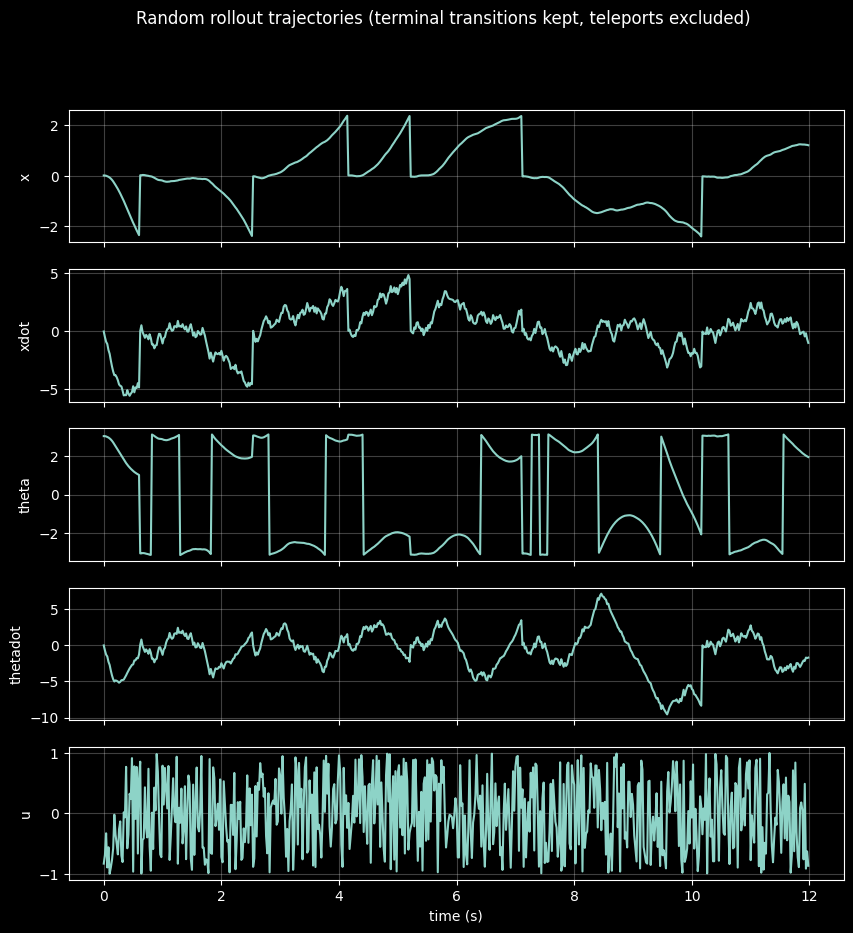

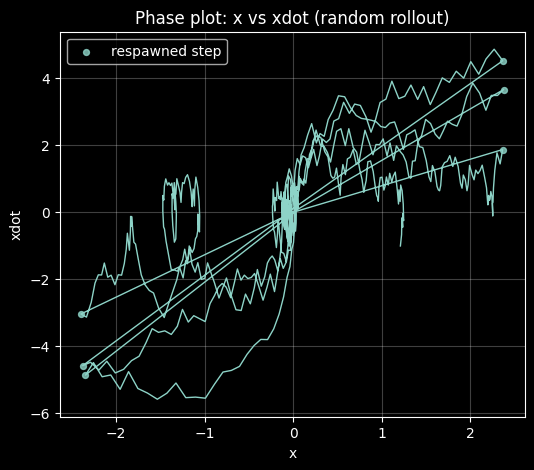

In [2]:
# ============================
# Cell 2 — Random data collection + PIL render (NO teleport training)
#   ✅ Uses info["terminal_obs"] when respawned=True (keeps real physics transition)
#   ✅ Never trains on reset teleport
#   ✅ Collects dataset in float64 (GP training friendly)
# ============================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
from PIL import Image, ImageDraw

NP_DTYPE = np.float64  # dataset dtype (GP side)

# ------------------------------------------------------------
# Pure-PIL renderer: (x, theta) -> RGB frame
# ------------------------------------------------------------
def render_cartpole_frame_from_state(
    x, theta,
    x_threshold=2.4,
    W=720, H=450,
    cart_width=70,
    cart_height=35,
    pole_length_px=180,
    wheel_radius=12,
):
    img = Image.new("RGB", (W, H), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    track_y = int(H * 0.70)
    draw.line((int(W * 0.10), track_y, int(W * 0.90), track_y), fill=(40, 40, 40), width=4)

    x = float(x)
    x_clipped = max(-x_threshold, min(x_threshold, x))
    t = (x_clipped + x_threshold) / (2.0 * x_threshold)
    cart_x = int(W * 0.10 + t * (W * 0.80))
    cart_y = track_y - cart_height // 2

    x0 = cart_x - cart_width // 2
    y0 = cart_y - cart_height // 2
    x1 = cart_x + cart_width // 2
    y1 = cart_y + cart_height // 2
    draw.rectangle((x0, y0, x1, y1), fill=(120, 160, 230), outline=(0, 0, 0))

    w1x = cart_x - int(cart_width * 0.25)
    w2x = cart_x + int(cart_width * 0.25)
    wy = track_y
    for wx in [w1x, w2x]:
        draw.ellipse((wx - wheel_radius, wy - wheel_radius, wx + wheel_radius, wy + wheel_radius),
                     fill=(60, 60, 60), outline=(0, 0, 0))

    theta = float(theta)
    pivot_x = cart_x
    pivot_y = y0  # cart top
    tip_x = pivot_x + int(pole_length_px * np.sin(theta))
    tip_y = pivot_y - int(pole_length_px * np.cos(theta))
    draw.line((pivot_x, pivot_y, tip_x, tip_y), fill=(200, 60, 60), width=8)
    draw.ellipse((pivot_x - 6, pivot_y - 6, pivot_x + 6, pivot_y + 6),
                 fill=(0, 0, 0), outline=(0, 0, 0))

    return np.array(img, dtype=np.uint8)

def show_gif(frames_uint8, fps=20):
    fig = plt.figure(figsize=(7.2, 4.5))
    plt.axis("off")
    im = plt.imshow(frames_uint8[0])

    def animate(i):
        im.set_data(frames_uint8[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(frames_uint8), interval=1000 / fps)
    plt.close(fig)
    display(HTML(anim.to_jshtml()))

# ------------------------------------------------------------
# Random collection (keeps REAL terminal transition when respawned)
# ------------------------------------------------------------
def collect_random_dataset_with_render(
    n_steps=1500,
    seed=0,
    resize=(720, 450),
    fps=20,
    edge_respawn=True,
    respawn_penalty=-2.0,
    verbose=False,
):
    env = make_env(
        render_mode=None,
        seed=seed,
        start_down=True,
        edge_respawn=edge_respawn,
        respawn_penalty=respawn_penalty,
    )

    obs, _ = env.reset(seed=seed)
    x, xdot, th, thdot = obs_to_state(obs)

    frames = []
    traj = {
        "x": [], "xdot": [], "theta": [], "thetadot": [],
        "u": [], "reward": [], "respawned": [],
    }

    X_list, ydx_list, ydxdot_list, ydth_list, ydthdot_list = [], [], [], [], []

    for t in range(n_steps):
        u = float(env.action_space.sample()[0])

        # frame from current state BEFORE stepping
        frames.append(render_cartpole_frame_from_state(x, th, W=resize[0], H=resize[1]))

        # step
        obs2, r, terminated, truncated, info = env.step(np.array([u], dtype=np.float32))

        respawned = bool(info.get("respawned", False))

        # use TRUE physics next_obs if respawned
        if respawned and ("terminal_obs" in info):
            obs2_for_training = info["terminal_obs"]
        else:
            obs2_for_training = obs2

        x2, xdot2, th2, thdot2 = obs_to_state(obs2_for_training)

        # logs
        traj["x"].append(x); traj["xdot"].append(xdot); traj["theta"].append(th); traj["thetadot"].append(thdot)
        traj["u"].append(u); traj["reward"].append(float(r)); traj["respawned"].append(respawned)

        # ALWAYS add a valid transition (no teleports)
        X = state_to_features(x, xdot, th, thdot, u, dtype=NP_DTYPE).astype(NP_DTYPE)
        dx = float(x2 - x)
        dxdot = float(xdot2 - xdot)
        dth = float(wrap_pi(th2 - th))
        dthdot = float(thdot2 - thdot)

        X_list.append(X)
        ydx_list.append([dx])
        ydxdot_list.append([dxdot])
        ydth_list.append([dth])
        ydthdot_list.append([dthdot])

        if verbose and (t % 200 == 0):
            print(f"[t={t}] respawned={respawned}  x={x:.2f} th={th:.2f} u={u:+.2f}")

        # advance CONTROL state using returned obs2 (which is reset_obs if respawned)
        x, xdot, th, thdot = obs_to_state(obs2)

    env.close()

    X0 = np.asarray(X_list, dtype=NP_DTYPE)
    Ydx0 = np.asarray(ydx_list, dtype=NP_DTYPE)
    Ydxdot0 = np.asarray(ydxdot_list, dtype=NP_DTYPE)
    Ydth0 = np.asarray(ydth_list, dtype=NP_DTYPE)
    Ydthdot0 = np.asarray(ydthdot_list, dtype=NP_DTYPE)

    return X0, Ydx0, Ydxdot0, Ydth0, Ydthdot0, frames, traj

# ------------------------------------------------------------
# Run data collection + visualize
# ------------------------------------------------------------
N_STEPS_RANDOM = 600
SEED_RANDOM = 0
FPS = 20
RECORD_RGB = True

X0, Ydx0, Ydxdot0, Ydth0, Ydthdot0, frames0, traj0 = collect_random_dataset_with_render(
    n_steps=N_STEPS_RANDOM,
    seed=SEED_RANDOM,
    resize=(720, 450),
    fps=FPS,
    edge_respawn=True,
    respawn_penalty=-2.0,
    verbose=False,
)

print("✅ Random dataset collected (NO teleport training)")
print("X0:", X0.shape)
print("Ydx0:", Ydx0.shape, " Ydxdot0:", Ydxdot0.shape, " Ydth0:", Ydth0.shape, " Ydthdot0:", Ydthdot0.shape)

if RECORD_RGB:
    show_gif(frames0, fps=FPS)

# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------
x_arr = np.array(traj0["x"])
xdot_arr = np.array(traj0["xdot"])
th_arr = np.array(traj0["theta"])
thdot_arr = np.array(traj0["thetadot"])
u_arr = np.array(traj0["u"])
rew_arr = np.array(traj0["reward"])
resp_arr = np.array(traj0["respawned"])
t = np.arange(len(x_arr)) * 0.02

fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
axs[0].plot(t, x_arr); axs[0].set_ylabel("x")
axs[1].plot(t, xdot_arr); axs[1].set_ylabel("xdot")
axs[2].plot(t, th_arr); axs[2].set_ylabel("theta")
axs[3].plot(t, thdot_arr); axs[3].set_ylabel("thetadot")
axs[4].plot(t, u_arr); axs[4].set_ylabel("u"); axs[4].set_xlabel("time (s)")
for ax in axs: ax.grid(True, alpha=0.25)
fig.suptitle("Random rollout trajectories (terminal transitions kept, teleports excluded)")
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(x_arr, xdot_arr, linewidth=1.0)
plt.scatter(x_arr[resp_arr], xdot_arr[resp_arr], s=18, label="respawned step", alpha=0.8)
plt.xlabel("x"); plt.ylabel("xdot")
plt.title("Phase plot: x vs xdot (random rollout)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()


In [3]:
# ============================
# Cell 3 — Stable SVGP init (for later OSGPR streaming)
# FIXES:
#   ✅ Use float64 for GPflow (much more stable)
#   ✅ Increase jitter
#   ✅ Safer kernel initialization
#   ✅ Smaller LR (avoid exploding nat params)
#   ✅ Sanity checks for NaNs/Infs
# ============================

import numpy as np
import tensorflow as tf
import gpflow
from gpflow.utilities import set_trainable

# ----------------------------
# 1) Use float64 + bigger jitter (key fix)
# ----------------------------
gpflow.config.set_default_float(tf.float64)
gpflow.config.set_default_jitter(1e-6)     # try 1e-5 if still unstable
GP_DTYPE = tf.float64

DTYPE_NP = np.float64

def assert_finite(name, arr):
    arr = np.asarray(arr)
    if not np.all(np.isfinite(arr)):
        bad = np.where(~np.isfinite(arr))
        raise ValueError(f"{name} has non-finite values at indices {bad}.")

assert_finite("X0", X0)
assert_finite("Ydx0", Ydx0)
assert_finite("Ydxdot0", Ydxdot0)
assert_finite("Ydth0", Ydth0)
assert_finite("Ydthdot0", Ydthdot0)

# ----------------------------
# 2) k-center inducing init (same as before, but float64)
# ----------------------------
def kcenter_greedy_indices(X, M, seed=0):
    N = X.shape[0]
    if M >= N:
        return np.arange(N, dtype=np.int64)

    rng = np.random.default_rng(seed)
    first = int(rng.integers(0, N))
    idx = [first]
    d2 = np.sum((X - X[first:first+1])**2, axis=1)

    for _ in range(1, M):
        i = int(np.argmax(d2))
        idx.append(i)
        d2 = np.minimum(d2, np.sum((X - X[i:i+1])**2, axis=1))

    return np.array(idx, dtype=np.int64)

def init_global_inducing_points(X0, M_GLOBAL_MAX=256, method="kcenter", seed=0):
    X0 = np.asarray(X0, dtype=DTYPE_NP)
    N0 = X0.shape[0]
    M_GLOBAL = int(min(M_GLOBAL_MAX, N0))

    if N0 <= M_GLOBAL_MAX:
        idx = np.arange(N0, dtype=np.int64)
        Z = X0.copy()
    else:
        if method == "kcenter":
            idx = kcenter_greedy_indices(X0, M_GLOBAL, seed=seed)
        elif method == "random":
            rng = np.random.default_rng(seed)
            idx = rng.choice(N0, size=M_GLOBAL, replace=False).astype(np.int64)
        else:
            raise ValueError(f"Unknown method={method}")
        Z = X0[idx].copy()

    return M_GLOBAL, Z, idx

M_GLOBAL_MAX = 256
M_GLOBAL, Z_GLOBAL, Z_INIT_IDX = init_global_inducing_points(X0, M_GLOBAL_MAX=M_GLOBAL_MAX, method="kcenter", seed=0)

print(f"✅ GLOBAL inducing init: N0={X0.shape[0]}  M_GLOBAL_MAX={M_GLOBAL_MAX}  ->  M_GLOBAL={M_GLOBAL}")
print("Z_GLOBAL shape:", Z_GLOBAL.shape)
print("Using ALL data as inducing?", (X0.shape[0] <= M_GLOBAL_MAX))

# ----------------------------
# 3) Model creation (SVGP)
#    Safer kernel init:
#      - variance = 1.0
#      - lengthscales = 0.5 (not too small/large)
# ----------------------------
def make_svgp_model(X, Y, Z_init, likelihood_var=1e-3):
    X = tf.convert_to_tensor(np.asarray(X, dtype=DTYPE_NP), dtype=GP_DTYPE)
    Y = tf.convert_to_tensor(np.asarray(Y, dtype=DTYPE_NP), dtype=GP_DTYPE)
    Z = tf.convert_to_tensor(np.asarray(Z_init, dtype=DTYPE_NP), dtype=GP_DTYPE)

    D = int(X.shape[1])

    kernel = gpflow.kernels.SquaredExponential(
        variance=tf.convert_to_tensor(1.0, dtype=GP_DTYPE),
        lengthscales=tf.convert_to_tensor(np.ones(D) * 0.5, dtype=GP_DTYPE),
    )

    inducing = gpflow.inducing_variables.InducingPoints(Z)

    m = gpflow.models.SVGP(
        kernel=kernel,
        likelihood=gpflow.likelihoods.Gaussian(variance=tf.convert_to_tensor(likelihood_var, dtype=GP_DTYPE)),
        inducing_variable=inducing,
        num_latent_gps=1,
        whiten=True,
    )
    return m

m_dx     = make_svgp_model(X0, Ydx0,     Z_GLOBAL, likelihood_var=1e-3)
m_dxdot  = make_svgp_model(X0, Ydxdot0,  Z_GLOBAL, likelihood_var=1e-3)
m_dth    = make_svgp_model(X0, Ydth0,    Z_GLOBAL, likelihood_var=1e-3)
m_dthdot = make_svgp_model(X0, Ydthdot0, Z_GLOBAL, likelihood_var=1e-3)

# keep likelihood variance fixed (stable)
set_trainable(m_dx.likelihood.variance, False)
set_trainable(m_dxdot.likelihood.variance, False)
set_trainable(m_dth.likelihood.variance, False)
set_trainable(m_dthdot.likelihood.variance, False)

print("✅ Built initial sparse models (SVGP) for: Δx, Δxdot, Δθ, Δθdot")

# ----------------------------
# 4) Stable training loop
#    - smaller LR
#    - stop early if NaN appears
# ----------------------------
def train_svgp(model, X, Y, iters=400, lr=0.005, verbose=True):
    X = tf.convert_to_tensor(np.asarray(X, dtype=DTYPE_NP), dtype=GP_DTYPE)
    Y = tf.convert_to_tensor(np.asarray(Y, dtype=DTYPE_NP), dtype=GP_DTYPE)

    opt = tf.optimizers.Adam(learning_rate=lr)

    @tf.function
    def step():
        with tf.GradientTape() as tape:
            loss = -model.elbo((X, Y))
        grads = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        return loss

    for k in range(iters):
        loss = step()
        if tf.math.is_nan(loss) or tf.math.is_inf(loss):
            raise FloatingPointError(f"SVGP training diverged at iter {k}: loss={loss.numpy()}")
        if verbose and (k % 50 == 0 or k == iters - 1):
            tf.print("iter", k, "loss", loss)

INIT_ITERS = 300
INIT_LR = 0.005

train_svgp(m_dx,     X0, Ydx0,     iters=INIT_ITERS, lr=INIT_LR, verbose=True)
train_svgp(m_dxdot,  X0, Ydxdot0,  iters=INIT_ITERS, lr=INIT_LR, verbose=True)
train_svgp(m_dth,    X0, Ydth0,    iters=INIT_ITERS, lr=INIT_LR, verbose=True)
train_svgp(m_dthdot, X0, Ydthdot0, iters=INIT_ITERS, lr=INIT_LR, verbose=True)

print("✅ Initial training complete (stable float64)")


✅ GLOBAL inducing init: N0=600  M_GLOBAL_MAX=256  ->  M_GLOBAL=256
Z_GLOBAL shape: (256, 6)
Using ALL data as inducing? False


I0000 00:00:1771189016.161168  384168 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9031 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


✅ Built initial sparse models (SVGP) for: Δx, Δxdot, Δθ, Δθdot
iter 0 loss 298937.44830268517


I0000 00:00:1771189019.058829  384528 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x4ed1f9c0


iter 50 loss 26766.865053252168
iter 100 loss 8008.5241394475952
iter 150 loss 3712.521526544062
iter 200 loss 1951.5649183261851
iter 250 loss 1038.9592890145109
iter 299 loss 508.05037804276509
iter 0 loss 332789.3164384038
iter 50 loss 28039.037670273025
iter 100 loss 8374.7278868412086
iter 150 loss 3940.0106175743185
iter 200 loss 2093.6700222868708
iter 250 loss 1127.6910504827124
iter 299 loss 562.64070757773493
iter 0 loss 299579.54614097386
iter 50 loss 26759.83840732697
iter 100 loss 8005.2692574073953
iter 150 loss 3713.6097590569707
iter 200 loss 1953.1356001534077
iter 250 loss 1038.4819381877237
iter 299 loss 505.66681464908049
iter 0 loss 357994.8279837849
iter 50 loss 29607.345317718693
iter 100 loss 8613.7811984319287
iter 150 loss 4043.5886736742332
iter 200 loss 2166.9078389831661
iter 250 loss 1191.7213114944186
iter 299 loss 621.13393361290366
✅ Initial training complete (stable float64)



GLOBAL EVAL: GLOBAL (initial, float64)
=== Test RMSE (global models) ===
dx        RMSE: 0.001042
dxdot     RMSE: 0.011554
dtheta    RMSE: 0.001301
dthetadot RMSE: 0.015508


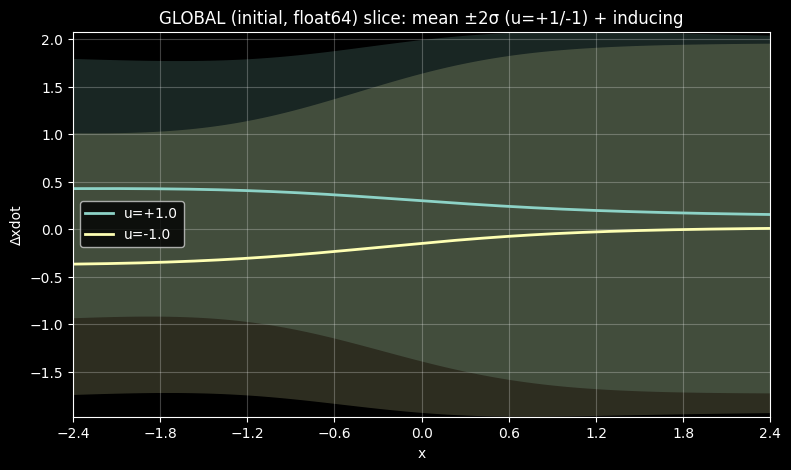

In [4]:
# ============================
# Cell 4 — (float64) Evaluate GLOBAL models + SAME plots as your original code
#   ✅ Test RMSE (global models)
#   ✅ Slice: sweep x, compare u=+1/-1, show mean ±2σ + training points + inducing marks
#   ✅ Surface: mean over (x, xdot) colored by std (+ inducing)
#   ❌ No std-only surface
#
# Assumes from Cell 3:
#   - gpflow default float is tf.float64
#   - X0, Ydx0, ... exist (we'll cast to float64 here safely)
#   - m_dx, m_dxdot, m_dth, m_dthdot exist
#   - Z_GLOBAL is fixed in inducing variables
# ============================

import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# ------------------------------------------------------------
# 0) Ensure float64 copies of datasets (safe, doesn't change originals)
# ------------------------------------------------------------
X0_64      = np.asarray(X0,      dtype=np.float64)
Ydx0_64    = np.asarray(Ydx0,    dtype=np.float64)
Ydxdot0_64 = np.asarray(Ydxdot0, dtype=np.float64)
Ydth0_64   = np.asarray(Ydth0,   dtype=np.float64)
Ydthdot0_64= np.asarray(Ydthdot0,dtype=np.float64)

# ------------------------------------------------------------
# 1) Make train/test split if not already defined (same spirit as original)
# ------------------------------------------------------------
def _ensure_split_from_X0(test_frac=0.2, seed=0):
    global Xtr, Xte, Ydx_tr, Ydx_te, Ydxdot_tr, Ydxdot_te, Ydth_tr, Ydth_te, Ydthdot_tr, Ydthdot_te
    if "Xtr" in globals() and "Xte" in globals():
        return

    rng = np.random.default_rng(seed)
    N = X0_64.shape[0]
    perm = rng.permutation(N)
    n_te = int(test_frac * N)
    te = perm[:n_te]
    tr = perm[n_te:]

    Xtr = X0_64[tr]
    Xte = X0_64[te]

    Ydx_tr, Ydx_te         = Ydx0_64[tr],     Ydx0_64[te]
    Ydxdot_tr, Ydxdot_te   = Ydxdot0_64[tr],  Ydxdot0_64[te]
    Ydth_tr, Ydth_te       = Ydth0_64[tr],    Ydth0_64[te]
    Ydthdot_tr, Ydthdot_te = Ydthdot0_64[tr], Ydthdot0_64[te]

_ensure_split_from_X0(test_frac=0.2, seed=0)

# ------------------------------------------------------------
# 2) Fast predict mean/std (keeps your "cached predictor" pattern if available)
# ------------------------------------------------------------
def gp_predict_mu_std_fast(model, X):
    X = np.asarray(X, dtype=np.float64)
    if hasattr(model, "predict_f_cached"):
        mu_tf, var_tf = model.predict_f_cached(X, full_cov=False)
    else:
        mu_tf, var_tf = model.predict_f(X, full_cov=False)
    mu = mu_tf.numpy().reshape(-1)
    var = var_tf.numpy().reshape(-1)
    std = np.sqrt(np.maximum(var, 1e-12))
    return mu, std

def get_inducing_Z_np(model):
    return model.inducing_variable.Z.numpy().astype(np.float64)

# ------------------------------------------------------------
# 3) Metrics
# ------------------------------------------------------------
def rmse_np(yhat, y):
    yhat = np.asarray(yhat).reshape(-1)
    y = np.asarray(y).reshape(-1)
    return float(np.sqrt(np.mean((yhat - y) ** 2)))

def print_global_rmse():
    mu_dx, _     = gp_predict_mu_std_fast(m_dx,     Xte)
    mu_dxdot, _  = gp_predict_mu_std_fast(m_dxdot,  Xte)
    mu_dth, _    = gp_predict_mu_std_fast(m_dth,    Xte)
    mu_dthdot, _ = gp_predict_mu_std_fast(m_dthdot, Xte)

    print("=== Test RMSE (global models) ===")
    print(f"dx        RMSE: {rmse_np(mu_dx,     Ydx_te):.6f}")
    print(f"dxdot     RMSE: {rmse_np(mu_dxdot,  Ydxdot_te):.6f}")
    print(f"dtheta    RMSE: {rmse_np(mu_dth,    Ydth_te):.6f}")
    print(f"dthetadot RMSE: {rmse_np(mu_dthdot, Ydthdot_te):.6f}")

# ------------------------------------------------------------
# 4) Slice plot: sweep physical x, compare u=+1/-1, mean ± 2σ + data + inducing
# ------------------------------------------------------------
def plot_slice_x_two_actions_cartpole(
    model,
    X_train, y_train,
    title="Slice",
    y_label="Δy",
    xdot_fixed=0.0,
    theta_fixed=0.0,
    thetadot_fixed=0.0,
    x_min=-2.4, x_max=2.4,
    n_grid=260,
    u_list=(+1.0, -1.0),
    y_min=None, y_max=None,
    x_tick_step=0.6,
    y_tick_step=None,
    show_data=True,
    show_inducing=True,
    tol_xdot_feat=0.12,
    tol_theta=0.25,
    tol_w_feat=0.12,
    tol_u=0.10,
):
    x_grid = np.linspace(x_min, x_max, n_grid, dtype=np.float64)
    Z = get_inducing_Z_np(model)

    curves = []
    auto_ymin, auto_ymax = +np.inf, -np.inf

    for u_fixed in u_list:
        X_query = np.vstack([
            state_to_features(float(x), float(xdot_fixed), float(theta_fixed), float(thetadot_fixed), float(u_fixed)).astype(np.float64)
            for x in x_grid
        ])
        mu, std = gp_predict_mu_std_fast(model, X_query)
        lo, hi = mu - 2 * std, mu + 2 * std
        curves.append((u_fixed, mu, lo, hi))
        auto_ymin = min(auto_ymin, float(lo.min()))
        auto_ymax = max(auto_ymax, float(hi.max()))

    if y_min is None: y_min = auto_ymin
    if y_max is None: y_max = auto_ymax

    plt.figure(figsize=(9, 5))

    X_train = np.asarray(X_train, dtype=np.float64)
    y_train = np.asarray(y_train, dtype=np.float64).reshape(-1)

    # fixed features for filtering "near slice"
    xdot_feat0 = np.tanh(float(xdot_fixed) / 3.0)
    w_feat0    = np.tanh(float(thetadot_fixed) / 8.0)

    if show_data:
        th_train = np.arctan2(X_train[:, 2], X_train[:, 3])
        mask_data = (
            (np.abs(X_train[:, 1] - xdot_feat0) < tol_xdot_feat) &
            (np.abs(wrap_pi(th_train - float(theta_fixed))) < tol_theta) &
            (np.abs(X_train[:, 4] - w_feat0) < tol_w_feat)
        )
        if np.any(mask_data):
            x_feat = X_train[mask_data, 0]
            x_phys = 2.4 * np.arctanh(np.clip(x_feat, -0.999999, 0.999999))
            plt.scatter(x_phys, y_train[mask_data], s=10, alpha=0.35, label="train (near slice)")

    for u_fixed, mu, lo, hi in curves:
        plt.plot(x_grid, mu, linewidth=2, label=f"u={u_fixed:+.1f}")
        plt.fill_between(x_grid, lo, hi, alpha=0.18)

    if show_inducing:
        thZ = np.arctan2(Z[:, 2], Z[:, 3])
        maskZ_base = (
            (np.abs(Z[:, 1] - xdot_feat0) < tol_xdot_feat) &
            (np.abs(wrap_pi(thZ - float(theta_fixed))) < tol_theta) &
            (np.abs(Z[:, 4] - w_feat0) < tol_w_feat)
        )
        # mark inducing at top edge
        for u_fixed, *_ in curves:
            maskZ = maskZ_base & (np.abs(Z[:, 5] - float(u_fixed)) < tol_u)
            if np.any(maskZ):
                x_feat = Z[maskZ, 0]
                x_phys = 2.4 * np.arctanh(np.clip(x_feat, -0.999999, 0.999999))
                plt.scatter(x_phys, np.full_like(x_phys, y_max), s=18, marker="x",
                            label=f"Z (u={u_fixed:+.1f})", alpha=0.85)

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel(y_label)
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    plt.grid(True, alpha=0.25)

    xticks = np.arange(np.ceil(x_min / x_tick_step) * x_tick_step, x_max + 1e-9, x_tick_step)
    plt.xticks(xticks)
    if y_tick_step is not None:
        yticks = np.arange(np.ceil(y_min / y_tick_step) * y_tick_step, y_max + 1e-9, y_tick_step)
        plt.yticks(yticks)

    plt.legend()
    plt.show()

# ------------------------------------------------------------
# 5) Surface: mean over (x, xdot) colored by std (+ inducing)
#    (Same as original; no std-only surface)
# ------------------------------------------------------------
def plot_surface_x_xdot_mean_colored_by_std(
    model,
    title="3D Surface (interactive)",
    z_label="Δy",
    theta_fixed=0.0,
    thetadot_fixed=0.0,
    u_fixed=+1.0,
    x_min=-2.4, x_max=2.4,
    xdot_min=-3.0, xdot_max=3.0,
    n_grid=70,
    show_inducing=True,
    tol_theta=0.25,
    tol_w_feat=0.12,
    tol_u=0.10,
):
    x_grid = np.linspace(x_min, x_max, n_grid, dtype=np.float64)
    xd_grid = np.linspace(xdot_min, xdot_max, n_grid, dtype=np.float64)
    X, XD = np.meshgrid(x_grid, xd_grid)

    X_feat = np.vstack([
        state_to_features(float(x), float(xdot), float(theta_fixed), float(thetadot_fixed), float(u_fixed)).astype(np.float64)
        for x, xdot in zip(X.ravel(), XD.ravel())
    ])

    mu, std = gp_predict_mu_std_fast(model, X_feat)
    Mean = mu.reshape(X.shape)
    Std  = std.reshape(X.shape)

    surface = go.Surface(
        x=X, y=XD, z=Mean,
        surfacecolor=Std,              # color by std
        colorscale="Viridis",
        colorbar=dict(title="Std"),
        opacity=0.95,
        showscale=True,
        name="surface",
    )
    traces = [surface]

    if show_inducing:
        Z = get_inducing_Z_np(model)
        thZ = np.arctan2(Z[:, 2], Z[:, 3])
        w_feat0 = np.tanh(float(thetadot_fixed) / 8.0)

        maskZ = (
            (np.abs(wrap_pi(thZ - float(theta_fixed))) < tol_theta) &
            (np.abs(Z[:, 4] - w_feat0) < tol_w_feat) &
            (np.abs(Z[:, 5] - float(u_fixed)) < tol_u)
        )

        if np.any(maskZ):
            Zm = Z[maskZ]
            x_phys    = 2.4 * np.arctanh(np.clip(Zm[:, 0], -0.999999, 0.999999))
            xdot_phys = 3.0 * np.arctanh(np.clip(Zm[:, 1], -0.999999, 0.999999))

            traces.append(
                go.Scatter3d(
                    x=x_phys, y=xdot_phys, z=np.full_like(x_phys, float(np.nanmax(Mean))),
                    mode="markers",
                    marker=dict(size=3.5),
                    name="inducing (filtered)",
                )
            )

    fig = go.Figure(data=traces)
    fig.update_layout(
        title=f"{title} | fixed u={float(u_fixed):+.1f}, theta={float(theta_fixed):.2f}, thetadot={float(thetadot_fixed):.2f}",
        scene=dict(
            xaxis=dict(title="x", range=[x_min, x_max]),
            yaxis=dict(title="xdot", range=[xdot_min, xdot_max]),
            zaxis=dict(title=z_label),
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        height=650,
    )
    fig.show()

# ------------------------------------------------------------
# 6) One-call eval bundle (use dxdot by default, like your original)
# ------------------------------------------------------------
def eval_and_plot_global(tag="GLOBAL", model_for_plots=None,
                         theta_fixed=0.0, thetadot_fixed=0.0, u_fixed=+1.0):
    if model_for_plots is None:
        model_for_plots = m_dxdot

    print("\n==============================")
    print(f"GLOBAL EVAL: {tag}")
    print("==============================")
    print_global_rmse()

    # Slice: x sweep, u=+1/-1
    plot_slice_x_two_actions_cartpole(
        model=model_for_plots,
        X_train=Xtr,
        y_train=Ydxdot_tr if (model_for_plots is m_dxdot) else Ydx_tr,
        title=f"{tag} slice: mean ±2σ (u=+1/-1) + inducing",
        y_label="Δxdot" if (model_for_plots is m_dxdot) else "Δx",
        xdot_fixed=0.0,
        theta_fixed=theta_fixed,
        thetadot_fixed=thetadot_fixed,
        x_min=-2.4, x_max=2.4,
        n_grid=260,
        u_list=(+1.0, -1.0),
        show_data=True,
        show_inducing=True,
    )

    # Surface: mean colored by std (no std-only surface)
    plot_surface_x_xdot_mean_colored_by_std(
        model=model_for_plots,
        title=f"{tag} surface: mean colored by std (+ inducing)",
        z_label="Δxdot" if (model_for_plots is m_dxdot) else "Δx",
        theta_fixed=theta_fixed,
        thetadot_fixed=thetadot_fixed,
        u_fixed=u_fixed,
        x_min=-2.4, x_max=2.4,
        xdot_min=-3.0, xdot_max=3.0,
        n_grid=70,
        show_inducing=True,
    )

# ----------------------------
# RUN
# ----------------------------
eval_and_plot_global(tag="GLOBAL (initial, float64)", model_for_plots=m_dxdot, u_fixed=+1.0)


In [5]:
# ============================
# Cell 5 — OSGPR streaming update (float64, fixed inducing)
# ============================

import numpy as np
import tensorflow as tf
import gpflow
from gpflow.utilities import set_trainable

GP_DTYPE = tf.float64
DTYPE_NP = np.float64

def extract_posterior_summary(model):
    """
    Get posterior summary at inducing points:
      Z, mu_u, Su, Kuu
    """
    Z = model.inducing_variable.Z
    Kuu = model.kernel.K(Z)

    mu = model.q_mu
    q_sqrt = model.q_sqrt
    L = q_sqrt[0] if len(q_sqrt.shape) == 3 else q_sqrt
    Sv = tf.matmul(L, L, transpose_b=True)

    if getattr(model, "whiten", False):
        jitter = gpflow.config.default_jitter()
        M = tf.shape(Kuu)[0]
        Lk = tf.linalg.cholesky(Kuu + jitter * tf.eye(M, dtype=GP_DTYPE))
        mu_u = tf.matmul(Lk, mu)
        Su_u = tf.matmul(Lk, tf.matmul(Sv, Lk, transpose_b=True))
    else:
        mu_u = mu
        Su_u = Sv

    return {"Z": Z, "mu_u": mu_u, "Su": Su_u, "Kuu": Kuu}

def make_osgpr_from_summary(kernel, likelihood, Z_new, X_new, Y_new, Z_old, mu_u_old, Su_old, Kuu_old):
    if not hasattr(gpflow.models, "OSGPR"):
        raise RuntimeError("gpflow.models.OSGPR not found.")
    inducing = gpflow.inducing_variables.InducingPoints(Z_new)
    return gpflow.models.OSGPR(
        data=(X_new, Y_new),
        kernel=kernel,
        likelihood=likelihood,
        inducing_variable=inducing,
        mu_old=mu_u_old,
        Su_old=Su_old,
        Kaa_old=Kuu_old,
        Z_old=Z_old,
    )

def train_osgpr(model, iters=50, lr=0.01):
    opt = tf.optimizers.Adam(learning_rate=lr)

    @tf.function
    def step():
        with tf.GradientTape() as tape:
            loss = -model.elbo()
        grads = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        return loss

    for k in range(iters):
        loss = step()
        if tf.math.is_nan(loss) or tf.math.is_inf(loss):
            raise FloatingPointError(f"OSGPR diverged at iter {k}: loss={loss.numpy()}")

def osgpr_stream_update_fixedZ(
    model_old,
    X_new_np,
    Y_new_np,
    Z_global_np,
    iters=50,
    lr=0.01,
    freeze_hypers=True,
):
    """
    Update model with new data using OSGPR; keep inducing points fixed to Z_global_np.
    """
    X_new = tf.convert_to_tensor(np.asarray(X_new_np, dtype=DTYPE_NP), dtype=GP_DTYPE)
    Y_new = tf.convert_to_tensor(np.asarray(Y_new_np, dtype=DTYPE_NP), dtype=GP_DTYPE)
    Z_new = tf.convert_to_tensor(np.asarray(Z_global_np, dtype=DTYPE_NP), dtype=GP_DTYPE)

    summ = extract_posterior_summary(model_old)

    model_new = make_osgpr_from_summary(
        kernel=model_old.kernel,
        likelihood=model_old.likelihood,
        Z_new=Z_new,
        X_new=X_new,
        Y_new=Y_new,
        Z_old=summ["Z"],
        mu_u_old=summ["mu_u"],
        Su_old=summ["Su"],
        Kuu_old=summ["Kuu"],
    )

    if freeze_hypers:
        set_trainable(model_new.kernel, False)
        set_trainable(model_new.likelihood, False)
        set_trainable(model_new.inducing_variable.Z, False)

    train_osgpr(model_new, iters=iters, lr=lr)
    return model_new


In [6]:
# ============================
# Cell 5 — OSGPR streaming update (float64, Z trainable each update)
# ============================

import numpy as np
import tensorflow as tf
import gpflow
from gpflow.utilities import set_trainable

GP_DTYPE = tf.float64
DTYPE_NP = np.float64

def extract_posterior_summary(model):
    Z = model.inducing_variable.Z
    Kuu = model.kernel.K(Z)

    mu = model.q_mu
    q_sqrt = model.q_sqrt
    L = q_sqrt[0] if len(q_sqrt.shape) == 3 else q_sqrt
    Sv = tf.matmul(L, L, transpose_b=True)

    if getattr(model, "whiten", False):
        jitter = gpflow.config.default_jitter()
        M = tf.shape(Kuu)[0]
        Lk = tf.linalg.cholesky(Kuu + jitter * tf.eye(M, dtype=GP_DTYPE))
        mu_u = tf.matmul(Lk, mu)
        Su_u = tf.matmul(Lk, tf.matmul(Sv, Lk, transpose_b=True))
    else:
        mu_u = mu
        Su_u = Sv

    return {"Z": Z, "mu_u": mu_u, "Su": Su_u, "Kuu": Kuu}

def make_osgpr_from_summary(kernel, likelihood, Z_new, X_new, Y_new, Z_old, mu_u_old, Su_old, Kuu_old):
    if not hasattr(gpflow.models, "OSGPR"):
        raise RuntimeError("gpflow.models.OSGPR not found.")
    inducing = gpflow.inducing_variables.InducingPoints(Z_new)
    return gpflow.models.OSGPR(
        data=(X_new, Y_new),
        kernel=kernel,
        likelihood=likelihood,
        inducing_variable=inducing,
        mu_old=mu_u_old,
        Su_old=Su_old,
        Kaa_old=Kuu_old,
        Z_old=Z_old,
    )

def train_osgpr(model, iters=50, lr=0.01):
    opt = tf.optimizers.Adam(learning_rate=lr)

    @tf.function
    def step():
        with tf.GradientTape() as tape:
            loss = -model.elbo()
        grads = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        return loss

    for k in range(iters):
        loss = step()
        if tf.math.is_nan(loss) or tf.math.is_inf(loss):
            raise FloatingPointError(f"OSGPR diverged at iter {k}: loss={loss.numpy()}")

def osgpr_stream_update_trainableZ(
    model_old,
    X_new_np,
    Y_new_np,
    iters=50,
    lr=0.01,
    freeze_hypers=True,
):
    X_new = tf.convert_to_tensor(np.asarray(X_new_np, dtype=DTYPE_NP), dtype=GP_DTYPE)
    Y_new = tf.convert_to_tensor(np.asarray(Y_new_np, dtype=DTYPE_NP), dtype=GP_DTYPE)

    summ = extract_posterior_summary(model_old)

    Z_init = tf.identity(summ["Z"])

    model_new = make_osgpr_from_summary(
        kernel=model_old.kernel,
        likelihood=model_old.likelihood,
        Z_new=Z_init,
        X_new=X_new,
        Y_new=Y_new,
        Z_old=summ["Z"],
        mu_u_old=summ["mu_u"],
        Su_old=summ["Su"],
        Kuu_old=summ["Kuu"],
    )

    if freeze_hypers:
        set_trainable(model_new.kernel, False)
        set_trainable(model_new.likelihood, False)

    set_trainable(model_new.inducing_variable.Z, True)

    train_osgpr(model_new, iters=iters, lr=lr)
    return model_new


In [7]:
# ============================
# Cell 6 — Split global anchor selection (rare) and tube selection (every step), float64
#   ✅ Deterministic chi-square mass tube: chi2_radius_sq = chi2.ppf(alpha, df=D)
# ============================

import numpy as np
import tensorflow as tf
from scipy.stats import chi2  # <-- NEW

NP_DTYPE = np.float64
TF_DTYPE = tf.float64

# ---------- D-opt greedy ----------

def greedy_dopt_select_from_kernel(K, k, jitter=1e-6, log_eps=1e-300):
    K = np.asarray(K, dtype=np.float64)
    n = K.shape[0]
    k = int(min(k, n))
    if k <= 0:
        return np.zeros((0,), dtype=np.int64)

    diag = np.diag(K).copy() + float(jitter)
    chosen = []
    Lchol = None

    for t in range(k):
        if t == 0:
            safe = np.maximum(diag, log_eps)
            i = int(np.argmax(np.log(safe)))
            chosen.append(i)
            Lchol = np.sqrt(max(diag[i], log_eps)).reshape(1, 1)
            continue

        S = np.array(chosen, dtype=np.int64)

        K_S = K[:, S]                       # (n,t)
        v = np.linalg.solve(Lchol, K_S.T)   # (t,n)
        sq = np.sum(v * v, axis=0)          # (n,)
        schur = diag - sq

        schur[S] = -np.inf

        schur_pos = np.maximum(schur, log_eps)
        scores = np.log(schur_pos)
        scores[S] = -np.inf

        i = int(np.argmax(scores))
        chosen.append(i)

        k_iS = K[i, S].reshape(1, -1)
        w = np.linalg.solve(Lchol, k_iS.T)
        alpha2 = diag[i] - float(np.sum(w * w))
        alpha2 = max(alpha2, log_eps)
        alpha = np.sqrt(alpha2)

        Lnew = np.zeros((t + 1, t + 1), dtype=np.float64)
        Lnew[:t, :t] = Lchol
        Lnew[t, :t] = w.reshape(-1)
        Lnew[t, t] = alpha
        Lchol = Lnew

    return np.array(chosen, dtype=np.int64)


# ---------- weights + tube stats ----------

def normalize_nonnegative_weights(w, eps=1e-12):
    w = np.asarray(w, dtype=NP_DTYPE).reshape(-1)
    w = np.maximum(w, 0.0)
    s = float(np.sum(w))
    if s < eps:
        return np.ones_like(w) / max(len(w), 1)
    return w / s

def compute_weighted_moments(rollout_inputs, rollout_weights):
    X = np.asarray(rollout_inputs, dtype=NP_DTYPE)  # (K,H,D)
    K, H, D = X.shape
    w = normalize_nonnegative_weights(rollout_weights).reshape(K, 1, 1)

    tube_mean = np.sum(w * X, axis=0)  # (H,D)
    Xc = X - tube_mean[None, :, :]
    tube_cov = np.einsum("khd,khe->hde", (w * Xc), Xc)  # (H,D,D)
    return tube_mean, tube_cov

def min_mahalanobis_and_argmin(points_Z, tube_mean, tube_cov, cov_eps=1e-6):
    Z = np.asarray(points_Z, dtype=NP_DTYPE)
    mu = np.asarray(tube_mean, dtype=NP_DTYPE)
    Sig = np.asarray(tube_cov, dtype=NP_DTYPE)

    M, D = Z.shape
    H = mu.shape[0]
    I = np.eye(D, dtype=NP_DTYPE)

    dmin = np.full((M,), np.inf, dtype=NP_DTYPE)
    tmin = np.zeros((M,), dtype=np.int64)

    for t in range(H):
        St = Sig[t] + cov_eps * I
        L = np.linalg.cholesky(St)

        diff = (Z - mu[t:t+1, :]).T
        y = np.linalg.solve(L, diff)
        y2 = np.linalg.solve(L.T, y)
        quad = np.sum(diff * y2, axis=0)

        mask = quad < dmin
        dmin[mask] = quad[mask]
        tmin[mask] = t

    return dmin, tmin

def split_even_quota(total, num_bins):
    num_bins = int(max(1, num_bins))
    base = total // num_bins
    rem = total - base * num_bins
    q = np.full((num_bins,), base, dtype=np.int64)
    if rem > 0:
        q[:rem] += 1
    return q

def get_Z_global(model):
    return model.inducing_variable.Z.numpy().astype(NP_DTYPE)

# ---------- NEW: deterministic chi-square radius ----------

def chi2_radius_sq(alpha, D):
    """
    Deterministic radius threshold for Mahalanobis tube:
        (x-mu)^T Sigma^{-1} (x-mu) <= chi2.ppf(alpha, df=D)
    """
    alpha = float(alpha)
    D = int(D)
    alpha = min(max(alpha, 1e-6), 1.0 - 1e-12)
    return float(chi2.ppf(alpha, df=D))


# ---------- 1) Global anchor selection (call only after global update) ----------

def select_global_anchors(model, num_anchors=16, dopt_jitter=1e-6):
    """
    Select anchors across the entire current Z_global via greedy D-opt.
    Call this only when the global model/inducing locations Z_global have been updated.
    Returns indices into Z_global.
    """
    Zg = get_Z_global(model)
    M = Zg.shape[0]
    num_anchors = int(min(num_anchors, M))
    if num_anchors <= 0:
        return np.zeros((0,), dtype=np.int64)

    K_all = model.kernel.K(tf.convert_to_tensor(Zg, dtype=TF_DTYPE)).numpy().astype(NP_DTYPE)
    anchor_idx = greedy_dopt_select_from_kernel(K_all, k=num_anchors, jitter=dopt_jitter)
    return anchor_idx.astype(np.int64)


# ---------- 2) Tube subset selection (call every step) ----------

def select_tube_subset(
    model,
    rollout_inputs,        # (K,H,D) GP-input rollouts
    rollout_weights,       # (K,)
    total_subset_size=64,
    anchor_idx=None,       # indices into Z_global (fixed until next global update)
    time_bins=16,
    cov_eps=1e-6,
    dopt_jitter=1e-6,
    fallback_candidates=400,

    # --- NEW: choose ONE of the following two ---
    alpha=None,            # e.g. 0.99 (recommended for paper)
    chi2_radius_sq_override=None,  # if you insist on passing a scalar threshold
):
    """
    Build a confidence tube from rollouts and fill the remaining budget (total_subset_size - len(anchors))
    using stratified greedy D-opt inside the tube, excluding anchors.

    Deterministic tube threshold:
        chi2_radius_sq = chi2.ppf(alpha, df=D)

    Returns:
      subset_idx: (total_subset_size,) indices into Z_global (anchors + tube points)
      tube_mean, tube_cov
      tube_candidates_idx
      chi2_radius_sq_used
    """
    Zg = get_Z_global(model)
    M = Zg.shape[0]

    if anchor_idx is None:
        anchor_idx = np.zeros((0,), dtype=np.int64)
    anchor_idx = np.unique(np.asarray(anchor_idx, dtype=np.int64))
    anchor_idx = anchor_idx[(anchor_idx >= 0) & (anchor_idx < M)]

    tube_mean, tube_cov = compute_weighted_moments(rollout_inputs, rollout_weights)
    H, D = tube_mean.shape[0], tube_mean.shape[1]

    # --- NEW: determine chi2 threshold deterministically ---
    if chi2_radius_sq_override is not None:
        chi2_thr = float(chi2_radius_sq_override)
    else:
        if alpha is None:
            raise ValueError("select_tube_subset: provide alpha (e.g. 0.99) or chi2_radius_sq_override.")
        chi2_thr = chi2_radius_sq(alpha, D)

    dmin, tmin = min_mahalanobis_and_argmin(Zg, tube_mean, tube_cov, cov_eps=cov_eps)
    tube_candidates_idx = np.where(dmin <= chi2_thr)[0].astype(np.int64)

    remaining_budget = int(total_subset_size - anchor_idx.size)
    remaining_budget = max(0, remaining_budget)

    # If too few tube candidates to fill, expand by nearest dmin
    if tube_candidates_idx.size < remaining_budget:
        L = int(min(max(fallback_candidates, remaining_budget), M))
        tube_candidates_idx = np.argsort(dmin)[:L].astype(np.int64)

    # Exclude anchors from tube pool
    tube_pool = tube_candidates_idx[~np.isin(tube_candidates_idx, anchor_idx)]
    tmin_pool = tmin[tube_pool]

    selected = set(int(i) for i in anchor_idx)

    # Stratified fill across horizon
    if remaining_budget > 0 and tube_pool.size > 0:
        B = int(max(1, min(time_bins, H)))
        edges = np.linspace(0, H, B + 1, dtype=np.int64)
        quotas = split_even_quota(remaining_budget, B)

        for b in range(B):
            if len(selected) >= total_subset_size:
                break

            a, c = int(edges[b]), int(edges[b + 1])
            if c <= a:
                continue

            in_bin = (tmin_pool >= a) & (tmin_pool < c)
            bin_pool = tube_pool[in_bin]
            if bin_pool.size == 0:
                continue

            k_b = int(min(quotas[b], bin_pool.size, total_subset_size - len(selected)))
            if k_b <= 0:
                continue

            Zb = Zg[bin_pool]
            Kb = model.kernel.K(tf.convert_to_tensor(Zb, dtype=TF_DTYPE)).numpy().astype(NP_DTYPE)
            pick = greedy_dopt_select_from_kernel(Kb, k=k_b, jitter=dopt_jitter)

            for gidx in bin_pool[pick]:
                selected.add(int(gidx))

    # Fill any remaining slots by D-opt over leftover tube pool
    if len(selected) < total_subset_size:
        need = int(total_subset_size - len(selected))
        leftover = tube_pool[~np.isin(tube_pool, np.array(list(selected), dtype=np.int64))]
        if leftover.size > 0 and need > 0:
            Zl = Zg[leftover]
            Kl = model.kernel.K(tf.convert_to_tensor(Zl, dtype=TF_DTYPE)).numpy().astype(NP_DTYPE)
            pick = greedy_dopt_select_from_kernel(Kl, k=min(need, leftover.size), jitter=dopt_jitter)
            for gidx in leftover[pick]:
                selected.add(int(gidx))

    # Last-resort fill (rare): nearest-by-dmin among remaining global points
    if len(selected) < total_subset_size:
        need = int(total_subset_size - len(selected))
        remaining = np.setdiff1d(np.arange(M, dtype=np.int64), np.array(list(selected), dtype=np.int64), assume_unique=False)
        if remaining.size > 0:
            order = remaining[np.argsort(dmin[remaining])]
            for gidx in order[:need]:
                selected.add(int(gidx))

    subset_idx = np.array(sorted(selected), dtype=np.int64)[:total_subset_size]
    return subset_idx, tube_mean, tube_cov, tube_candidates_idx, chi2_thr


In [8]:
# ============================
# Cell 7A — MPPI + Online global SVGP + planning-tube Z_local ⊂ Z_global  (PLSSGP)
#   ✅ Each RUN independent: restore GLOBAL models to scratch params captured once
#   ✅ Episodes within a run keep learning (dataset grows across episodes)
#   ✅ Fixed success counting (no false negatives)
#   ✅ One stitched GIF per RUN
#   ✅ Logs wall-time vs timestep + training-time vs timestep (exclude ALL render time)
#   ✅ End of each RUN: Plotly surface for final global Δxdot
# ============================

import time
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
from gpflow.utilities import set_trainable, parameter_dict, multiple_assign
import plotly.graph_objects as go

# -----------------------
# Dtypes (float64 everywhere)
# -----------------------
NP_DTYPE = np.float64
TF_DTYPE = tf.float64
gpflow.config.set_default_float(TF_DTYPE)
gpflow.config.set_default_jitter(1e-6)

# -----------------------
# MPPI config (same as your PLSSGP)
# -----------------------
HORIZON   = 50
K_SAMPLES = 256
SIGMA     = 0.6
LAMBDA    = 1.0

X_BAND      = 0.70
UPRIGHT_COS = 0.85
HOLD_GOAL   = 150

CENTER_W  = 1.0
U_W       = 0.005
UPRIGHT_W = 2.0

EXPLORE_STEPS = 200
UNC_W_MAX     = 15.0
UNC_W_MIN     = 0.0

RETRAIN_EVERY = 40
RETRAIN_STEPS = 200
RETRAIN_LR    = 2e-3

NUM_ANCHORS       = 16
LOCAL_SUBSET_SIZE = 64
TUBE_ALPHA        = 0.99
TUBE_NUM_BINS     = 5

N_RUNS           = 3
EPISODES_PER_RUN = 3
MAX_STEPS_PER_EP = 600

RENDER_W, RENDER_H = 720, 450
FPS_RENDER = 20

if "U_MIN" not in globals(): U_MIN = -1.0
if "U_MAX" not in globals(): U_MAX = +1.0

# -----------------------
# Plotting globals (same as your existing helper)
# -----------------------
PLOT_X_SCALE = 2.4
PLOT_V_SCALE = 3.0
PLOT_W_SCALE = 8.0

PLOT_TH_FIXED    = 0.0
PLOT_THDOT_FIXED = 0.0
PLOT_U_FIXED     = 0.0

PLOT_X_MIN, PLOT_X_MAX = -2.4, 2.4
PLOT_V_MIN, PLOT_V_MAX = -3.0, 3.0

PLOT_NX = 121
PLOT_NV = 121

def _atanh_safe(z, eps=1e-6):
    z = np.asarray(z, dtype=NP_DTYPE)
    z = np.clip(z, -1.0 + eps, 1.0 - eps)
    return 0.5 * (np.log1p(z) - np.log1p(-z))

def feat_x_to_phys(x_feat):
    return PLOT_X_SCALE * _atanh_safe(x_feat)

def feat_xdot_to_phys(xdot_feat):
    return PLOT_V_SCALE * _atanh_safe(xdot_feat)

_xs = np.linspace(PLOT_X_MIN, PLOT_X_MAX, PLOT_NX, dtype=NP_DTYPE)
_vs = np.linspace(PLOT_V_MIN, PLOT_V_MAX, PLOT_NV, dtype=NP_DTYPE)
PLOT_XMESH, PLOT_VMESH = np.meshgrid(_xs, _vs, indexing="xy")
_x_feat = np.tanh(PLOT_XMESH / PLOT_X_SCALE).astype(NP_DTYPE)
_v_feat = np.tanh(PLOT_VMESH / PLOT_V_SCALE).astype(NP_DTYPE)
_w_feat0 = np.tanh(PLOT_THDOT_FIXED / PLOT_W_SCALE).astype(NP_DTYPE)

PLOT_XFEAT_GRID = np.stack([
    _x_feat.reshape(-1),
    _v_feat.reshape(-1),
    np.full(_x_feat.size, np.sin(PLOT_TH_FIXED), dtype=NP_DTYPE),
    np.full(_x_feat.size, np.cos(PLOT_TH_FIXED), dtype=NP_DTYPE),
    np.full(_x_feat.size, _w_feat0, dtype=NP_DTYPE),
    np.full(_x_feat.size, float(PLOT_U_FIXED), dtype=NP_DTYPE),
], axis=1).astype(NP_DTYPE)

def gp_predict_mu_std_fast(model, X_np):
    Xtf = tf.convert_to_tensor(np.asarray(X_np, dtype=NP_DTYPE), dtype=TF_DTYPE)
    mu, var = model.predict_f(Xtf)
    mu = mu.numpy().astype(NP_DTYPE).reshape(-1)
    std = np.sqrt(np.maximum(var.numpy().astype(NP_DTYPE).reshape(-1), 1e-12))
    return mu, std

def plot_surface_global_or_local_dxdot(model_like, is_local=False, Z_overlay=None,
                                      title="Surface", std_clim=None,
                                      Xmesh=PLOT_XMESH, Vmesh=PLOT_VMESH, Xfeat_grid=PLOT_XFEAT_GRID,
                                      show_colorbar=True):
    if not is_local:
        mu, std = gp_predict_mu_std_fast(model_like, Xfeat_grid)
        Mean = mu.reshape(Xmesh.shape)
        Std  = std.reshape(Xmesh.shape)
        Z = model_like.inducing_variable.Z.numpy()
        pred_local = None
    else:
        pred_local = model_like
        mu, var = pred_local(Xfeat_grid)
        Mean = np.asarray(mu).reshape(Xmesh.shape)
        Std  = np.sqrt(np.maximum(np.asarray(var), 1e-12)).reshape(Xmesh.shape)
        Z = Z_overlay

    cmin = cmax = None
    if std_clim is not None:
        cmin, cmax = float(std_clim[0]), float(std_clim[1])

    surface = go.Surface(
        x=Xmesh, y=Vmesh, z=Mean,
        surfacecolor=Std,
        colorscale="Viridis",
        cmin=cmin, cmax=cmax,
        colorbar=(dict(title="Std") if show_colorbar else None),
        showscale=bool(show_colorbar),
        opacity=0.95,
        name="surface"
    )
    fig = go.Figure(data=[surface])
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(title="x", range=[PLOT_X_MIN, PLOT_X_MAX]),
            yaxis=dict(title="xdot", range=[PLOT_V_MIN, PLOT_V_MAX]),
            zaxis=dict(title="Δxdot"),
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        height=620
    )
    fig.show()

# -----------------------
# helper: exploration weight
# -----------------------
@tf.function
def exploration_weight_tf(t_global):
    t = tf.cast(t_global, TF_DTYPE)
    explore = tf.cast(EXPLORE_STEPS, TF_DTYPE)
    a = tf.clip_by_value(1.0 - t / tf.maximum(explore, 1.0), 0.0, 1.0)
    return tf.cast(UNC_W_MIN, TF_DTYPE) + (tf.cast(UNC_W_MAX, TF_DTYPE) - tf.cast(UNC_W_MIN, TF_DTYPE)) * a

# -----------------------
# angle wrap
# -----------------------
@tf.function
def tf_wrap_pi(th):
    two_pi = tf.constant(2.0 * np.pi, dtype=TF_DTYPE)
    pi = tf.constant(np.pi, dtype=TF_DTYPE)
    return tf.math.floormod(th + pi, two_pi) - pi

# -----------------------
# features from state (must match your map)
# -----------------------
@tf.function
def tf_features_from_state(s, u, x_scale=2.4, v_scale=3.0, w_scale=8.0):
    x     = s[:, 0]
    xdot  = s[:, 1]
    th    = s[:, 2]
    thdot = s[:, 3]
    x_feat    = tf.math.tanh(x / tf.cast(x_scale, TF_DTYPE))
    xdot_feat = tf.math.tanh(xdot / tf.cast(v_scale, TF_DTYPE))
    w_feat    = tf.math.tanh(thdot / tf.cast(w_scale, TF_DTYPE))
    return tf.stack([x_feat, xdot_feat, tf.sin(th), tf.cos(th), w_feat, u], axis=1)

# -----------------------
# costs
# -----------------------
@tf.function
def stage_cost_cartpole_tf(S, U, x_init, unc_bonus=None, unc_w=0.0):
    th = S[:, 2]
    x  = S[:, 0]
    c = (
        tf.cast(UPRIGHT_W, TF_DTYPE) * (1.0 - tf.cos(th))
        + tf.cast(CENTER_W, TF_DTYPE) * tf.square(x - x_init)
        + tf.cast(U_W, TF_DTYPE) * tf.square(U)
    )
    if (unc_bonus is not None) and (unc_w > 0.0):
        c = c - tf.cast(unc_w, TF_DTYPE) * tf.cast(unc_bonus, TF_DTYPE)
    return c

@tf.function
def terminal_cost_hold_like_tf(S, x_init):
    th = S[:, 2]
    x  = S[:, 0]
    cT = tf.zeros_like(th)
    good = tf.logical_and(tf.cos(th) >= tf.cast(UPRIGHT_COS, TF_DTYPE),
                          tf.abs(x - x_init) <= tf.cast(X_BAND, TF_DTYPE))
    cT = tf.where(good, cT - tf.cast(5.0, TF_DTYPE), cT)
    return cT

# -----------------------
# ✅ success check (FIXED)
# -----------------------
def update_upright_streak(upright_streak, state_np, x_init):
    # state_np = [x, xdot, th, thdot] from REAL env next_state
    good = (np.cos(state_np[2]) >= UPRIGHT_COS) and (abs(state_np[0] - x_init) <= X_BAND)
    return (upright_streak + 1) if good else 0

# -----------------------
# local models: build once per run, update in-place each step
# -----------------------
def init_local_like_global(global_model, M, likelihood_var=1e-3):
    D = int(global_model.inducing_variable.Z.shape[1])
    Z_dummy = np.zeros((int(M), D), dtype=NP_DTYPE)
    kernel = global_model.kernel
    inducing = gpflow.inducing_variables.InducingPoints(tf.convert_to_tensor(Z_dummy, TF_DTYPE))
    m_loc = gpflow.models.SVGP(
        kernel=kernel,
        likelihood=gpflow.likelihoods.Gaussian(variance=tf.convert_to_tensor(likelihood_var, TF_DTYPE)),
        inducing_variable=inducing,
        num_latent_gps=1,
        whiten=True,
    )
    set_trainable(m_loc.likelihood.variance, False)
    set_trainable(m_loc.inducing_variable.Z, False)
    return m_loc

def update_local_from_global_inplace(global_model, local_model, Z_local_np, jitter=1e-6):
    Z_local = tf.convert_to_tensor(np.asarray(Z_local_np, dtype=NP_DTYPE), dtype=TF_DTYPE)
    local_model.inducing_variable.Z.assign(Z_local)

    mu_f, var_f = global_model.predict_f(Z_local)
    mu_f  = tf.reshape(mu_f,  (-1, 1))
    var_f = tf.reshape(var_f, (-1, 1))

    Kuu = local_model.kernel.K(Z_local)
    M = tf.shape(Kuu)[0]
    L = tf.linalg.cholesky(Kuu + tf.cast(jitter, TF_DTYPE) * tf.eye(M, dtype=TF_DTYPE))

    q_mu = tf.linalg.triangular_solve(L, mu_f)

    std_f = tf.sqrt(tf.maximum(var_f, tf.cast(1e-12, TF_DTYPE)))
    std_v = 0.75 * std_f
    q_sqrt = tf.linalg.diag(tf.reshape(std_v, (-1,)))
    q_sqrt = tf.reshape(q_sqrt, (1, tf.shape(q_sqrt)[0], tf.shape(q_sqrt)[1]))

    local_model.q_mu.assign(q_mu)
    local_model.q_sqrt.assign(q_sqrt)

# -----------------------
# MPPI step (TF/GPU) using locals
# -----------------------
@tf.function(reduce_retracing=True)
def mppi_step_tf(
    state0, x_init, u_nom, t_global,
    loc_dx, loc_dxdot, loc_dth, loc_dthdot,
    K=256, H=50, sigma=0.6, lam=1.0, u_min=-1.0, u_max=1.0,
):
    K = tf.cast(K, tf.int32)
    H = tf.cast(H, tf.int32)
    sigma = tf.cast(sigma, TF_DTYPE)
    lam   = tf.cast(lam,   TF_DTYPE)
    u_min = tf.cast(u_min, TF_DTYPE)
    u_max = tf.cast(u_max, TF_DTYPE)

    eps = tf.random.normal(shape=(K, H), mean=0.0, stddev=sigma, dtype=TF_DTYPE)
    U = tf.clip_by_value(u_nom[None, :] + eps, u_min, u_max)

    s = tf.tile(tf.reshape(tf.cast(state0, TF_DTYPE), (1, 4)), (K, 1))
    feat_ta = tf.TensorArray(dtype=TF_DTYPE, size=H, clear_after_read=False)
    costs = tf.zeros((K,), dtype=TF_DTYPE)

    unc_w = exploration_weight_tf(t_global)
    x_init = tf.cast(x_init, TF_DTYPE)

    t = tf.constant(0, dtype=tf.int32)
    def cond(t, s, costs, feat_ta): return t < H

    def body(t, s, costs, feat_ta):
        u_t = U[:, t]
        X_feat = tf_features_from_state(s, u_t)
        feat_ta = feat_ta.write(t, X_feat)

        mu_dx, _          = loc_dx.predict_f(X_feat)
        mu_dxdot, v_dxdot = loc_dxdot.predict_f(X_feat)
        mu_dth, _         = loc_dth.predict_f(X_feat)
        mu_dthdot, _      = loc_dthdot.predict_f(X_feat)

        dx     = tf.reshape(mu_dx, (-1,))
        dxdot  = tf.reshape(mu_dxdot, (-1,))
        dth    = tf.reshape(mu_dth, (-1,))
        dthdot = tf.reshape(mu_dthdot, (-1,))

        x     = s[:, 0] + dx
        xdot  = s[:, 1] + dxdot
        th    = tf_wrap_pi(s[:, 2] + dth)
        thdot = s[:, 3] + dthdot
        s_new = tf.stack([x, xdot, th, thdot], axis=1)

        unc_bonus = tf.reshape(v_dxdot, (-1,))
        costs_new = costs + stage_cost_cartpole_tf(s_new, u_t, x_init=x_init, unc_bonus=unc_bonus, unc_w=unc_w)
        return t + 1, s_new, costs_new, feat_ta

    _, s_final, costs, feat_ta = tf.while_loop(cond, body, [t, s, costs, feat_ta], parallel_iterations=1)
    costs = costs + terminal_cost_hold_like_tf(s_final, x_init=x_init)

    rollout_inputs = tf.transpose(feat_ta.stack(), perm=[1, 0, 2])  # (K,H,6)

    cmin = tf.reduce_min(costs)
    w_unnorm = tf.exp(-(costs - cmin) / tf.maximum(lam, tf.cast(1e-12, TF_DTYPE)))
    weights = w_unnorm / (tf.reduce_sum(w_unnorm) + tf.cast(1e-12, TF_DTYPE))

    u_nom_new = tf.reduce_sum(weights[:, None] * U, axis=0)
    u0 = u_nom_new[0]
    u_nom_new = tf.concat([u_nom_new[1:], u_nom_new[-1:]], axis=0)

    return u0, u_nom_new, rollout_inputs, weights

# -----------------------
# global retrain burst (same as your PLSSGP)
# -----------------------
def make_train_step(model, optimizer):
    @tf.function(reduce_retracing=True)
    def _step(Xb, Yb):
        with tf.GradientTape() as tape:
            loss = -model.elbo((Xb, Yb))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss
    return _step

def retrain_global_burst(X_all, Y_dx, Y_dxdot, Y_dth, Y_dthdot, steps=200, batch_size=256, lr=2e-3, seed=0):
    rng = np.random.default_rng(seed)
    N = int(X_all.shape[0])
    idx_all = np.arange(N)

    for m in (m_dx, m_dxdot, m_dth, m_dthdot):
        set_trainable(m.inducing_variable.Z, True)

    lr_f = float(lr)
    opt_dx     = tf.optimizers.Adam(learning_rate=lr_f)
    opt_dxdot  = tf.optimizers.Adam(learning_rate=lr_f)
    opt_dth    = tf.optimizers.Adam(learning_rate=lr_f)
    opt_dthdot = tf.optimizers.Adam(learning_rate=lr_f)

    step_dx     = make_train_step(m_dx, opt_dx)
    step_dxdot  = make_train_step(m_dxdot, opt_dxdot)
    step_dth    = make_train_step(m_dth, opt_dth)
    step_dthdot = make_train_step(m_dthdot, opt_dthdot)

    X_tf = tf.convert_to_tensor(np.asarray(X_all, dtype=NP_DTYPE), dtype=TF_DTYPE)
    Ydx_tf     = tf.convert_to_tensor(np.asarray(Y_dx, dtype=NP_DTYPE), dtype=TF_DTYPE)
    Ydxdot_tf  = tf.convert_to_tensor(np.asarray(Y_dxdot, dtype=NP_DTYPE), dtype=TF_DTYPE)
    Ydth_tf    = tf.convert_to_tensor(np.asarray(Y_dth, dtype=NP_DTYPE), dtype=TF_DTYPE)
    Ydthdot_tf = tf.convert_to_tensor(np.asarray(Y_dthdot, dtype=NP_DTYPE), dtype=TF_DTYPE)

    B = min(int(batch_size), N)
    for _ in range(int(steps)):
        b = rng.choice(idx_all, size=B, replace=False)
        Xb = tf.gather(X_tf, b)
        _  = step_dx(Xb, tf.gather(Ydx_tf, b))
        _  = step_dxdot(Xb, tf.gather(Ydxdot_tf, b))
        _  = step_dth(Xb, tf.gather(Ydth_tf, b))
        _  = step_dthdot(Xb, tf.gather(Ydthdot_tf, b))

    for m in (m_dx, m_dxdot, m_dth, m_dthdot):
        set_trainable(m.inducing_variable.Z, False)

# -----------------------
# ✅ CAPTURE “scratch init” params ONCE, but also provide a restore
#     so each run is independent even if you ran other cells.
# -----------------------
PLSSGP_SCRATCH = {
    "dx":     parameter_dict(m_dx),
    "dxdot":  parameter_dict(m_dxdot),
    "dth":    parameter_dict(m_dth),
    "dthdot": parameter_dict(m_dthdot),
}

def restore_plssgp_to_scratch():
    multiple_assign(m_dx,     PLSSGP_SCRATCH["dx"])
    multiple_assign(m_dxdot,  PLSSGP_SCRATCH["dxdot"])
    multiple_assign(m_dth,    PLSSGP_SCRATCH["dth"])
    multiple_assign(m_dthdot, PLSSGP_SCRATCH["dthdot"])

# -----------------------
# RUNS
# -----------------------
run_wall_traces  = []
run_train_traces = []

for run_id in range(N_RUNS):
    np.random.seed(100 + run_id)
    tf.random.set_seed(10_000 + run_id)

    # ✅ run independence
    restore_plssgp_to_scratch()

    X_global       = np.asarray(X0,      dtype=NP_DTYPE).copy()
    Ydx_global     = np.asarray(Ydx0,    dtype=NP_DTYPE).copy()
    Ydxdot_global  = np.asarray(Ydxdot0, dtype=NP_DTYPE).copy()
    Ydth_global    = np.asarray(Ydth0,   dtype=NP_DTYPE).copy()
    Ydthdot_global = np.asarray(Ydthdot0,dtype=NP_DTYPE).copy()

    env = make_env(render_mode=None, seed=1000 + run_id, start_down=True, edge_respawn=True)

    anchors_idx = select_global_anchors(m_dx, num_anchors=NUM_ANCHORS, dopt_jitter=1e-6)

    # locals per run
    Mloc = int(LOCAL_SUBSET_SIZE)
    loc_dx     = init_local_like_global(m_dx,     Mloc, likelihood_var=1e-3)
    loc_dxdot  = init_local_like_global(m_dxdot,  Mloc, likelihood_var=1e-3)
    loc_dth    = init_local_like_global(m_dth,    Mloc, likelihood_var=1e-3)
    loc_dthdot = init_local_like_global(m_dthdot, Mloc, likelihood_var=1e-3)

    # init local subset
    Zg_np = m_dx.inducing_variable.Z.numpy().astype(NP_DTYPE)
    init_subset = np.arange(min(LOCAL_SUBSET_SIZE, Zg_np.shape[0]), dtype=np.int64)
    Zloc0 = Zg_np[init_subset]
    update_local_from_global_inplace(m_dx,     loc_dx,     Zloc0)
    update_local_from_global_inplace(m_dxdot,  loc_dxdot,  Zloc0)
    update_local_from_global_inplace(m_dth,    loc_dth,    Zloc0)
    update_local_from_global_inplace(m_dthdot, loc_dthdot, Zloc0)

    wall_time_cum  = []
    train_time_cum = []
    t_run0    = time.perf_counter()
    train_acc = 0.0
    vis_acc   = 0.0
    total_exec_steps = 0

    run_frames   = []
    ep_summaries = []

    for ep in range(EPISODES_PER_RUN):
        obs, _ = env.reset(seed=2000 + 100*run_id + ep)
        x, xdot, th, thdot = obs_to_state(obs)
        state = np.asarray([x, xdot, th, thdot], dtype=NP_DTYPE)
        x_init = float(state[0])

        u_nom = np.zeros((HORIZON,), dtype=NP_DTYPE)
        upright_streak = 0
        success_step = None

        X_new_buf, Ydx_new_buf, Ydxdot_new_buf, Ydth_new_buf, Ydthdot_new_buf = [], [], [], [], []
        ep_frames = []
        ep_steps = 0

        for step in range(MAX_STEPS_PER_EP):
            u0_tf, u_nom_tf, rollout_inputs_tf, weights_tf = mppi_step_tf(
                state0=tf.convert_to_tensor(state, dtype=TF_DTYPE),
                x_init=tf.convert_to_tensor(x_init, dtype=TF_DTYPE),
                u_nom=tf.convert_to_tensor(u_nom, dtype=TF_DTYPE),
                t_global=tf.convert_to_tensor(total_exec_steps, dtype=tf.int32),
                loc_dx=loc_dx, loc_dxdot=loc_dxdot, loc_dth=loc_dth, loc_dthdot=loc_dthdot,
                K=K_SAMPLES, H=HORIZON, sigma=SIGMA, lam=LAMBDA,
                u_min=float(U_MIN), u_max=float(U_MAX),
            )
            u0 = float(u0_tf.numpy())
            u_nom = u_nom_tf.numpy().astype(NP_DTYPE)
            rollout_inputs = rollout_inputs_tf.numpy().astype(NP_DTYPE)
            weights = weights_tf.numpy().astype(NP_DTYPE)

            next_obs, reward, terminated, truncated, info = env.step(np.array([u0], dtype=np.float32))
            nx, nxdot, nth, nthdot = obs_to_state(next_obs)
            next_state = np.asarray([nx, nxdot, nth, nthdot], dtype=NP_DTYPE)

            # render
            t_vis0 = time.perf_counter()
            ep_frames.append(render_cartpole_frame_from_state(float(next_state[0]), float(next_state[2]), W=RENDER_W, H=RENDER_H))
            t_vis1 = time.perf_counter()
            vis_acc += (t_vis1 - t_vis0)

            # training transition (respect respawn)
            respawned = bool(info.get("respawned", False))
            if respawned and ("terminal_obs" in info):
                train_next_obs = info["terminal_obs"]
            else:
                train_next_obs = next_obs

            tx, txdot, tth, tthdot = obs_to_state(train_next_obs)
            train_next_state = np.asarray([tx, txdot, tth, tthdot], dtype=NP_DTYPE)

            Xfeat = np.asarray(
                state_to_features(float(state[0]), float(state[1]), float(state[2]), float(state[3]), float(u0), dtype=NP_DTYPE),
                dtype=NP_DTYPE
            )
            dx     = float(train_next_state[0] - state[0])
            dxdot  = float(train_next_state[1] - state[1])
            dth    = float(wrap_pi(train_next_state[2] - state[2]))
            dthdot = float(train_next_state[3] - state[3])

            X_new_buf.append(Xfeat)
            Ydx_new_buf.append([dx])
            Ydxdot_new_buf.append([dxdot])
            Ydth_new_buf.append([dth])
            Ydthdot_new_buf.append([dthdot])

            # ✅ success check uses REAL next_state (not terminal_obs)
            upright_streak = update_upright_streak(upright_streak, next_state, x_init)

            # tube subset + update locals
            subset_idx, tube_mean, tube_cov, cand_idx, chi2_thr = select_tube_subset(
                model=m_dx,
                rollout_inputs=rollout_inputs,
                rollout_weights=weights,
                total_subset_size=LOCAL_SUBSET_SIZE,
                anchor_idx=anchors_idx,
                time_bins=TUBE_NUM_BINS,
                cov_eps=1e-6,
                dopt_jitter=1e-6,
                fallback_candidates=400,
                alpha=TUBE_ALPHA,
            )
            Zg_np = m_dx.inducing_variable.Z.numpy().astype(NP_DTYPE)
            Zloc = Zg_np[np.asarray(subset_idx, dtype=np.int64)]
            update_local_from_global_inplace(m_dx,     loc_dx,     Zloc)
            update_local_from_global_inplace(m_dxdot,  loc_dxdot,  Zloc)
            update_local_from_global_inplace(m_dth,    loc_dth,    Zloc)
            update_local_from_global_inplace(m_dthdot, loc_dthdot, Zloc)

            # advance
            state = next_state
            total_exec_steps += 1
            ep_steps += 1

            # retrain
            if (total_exec_steps % RETRAIN_EVERY) == 0:
                X_new = np.asarray(X_new_buf, dtype=NP_DTYPE)
                Ydx_new     = np.asarray(Ydx_new_buf, dtype=NP_DTYPE)
                Ydxdot_new  = np.asarray(Ydxdot_new_buf, dtype=NP_DTYPE)
                Ydth_new    = np.asarray(Ydth_new_buf, dtype=NP_DTYPE)
                Ydthdot_new = np.asarray(Ydthdot_new_buf, dtype=NP_DTYPE)

                X_global       = np.concatenate([X_global,       X_new], axis=0)
                Ydx_global     = np.concatenate([Ydx_global,     Ydx_new], axis=0)
                Ydxdot_global  = np.concatenate([Ydxdot_global,  Ydxdot_new], axis=0)
                Ydth_global    = np.concatenate([Ydth_global,    Ydth_new], axis=0)
                Ydthdot_global = np.concatenate([Ydthdot_global, Ydthdot_new], axis=0)

                t_tr0 = time.perf_counter()
                retrain_global_burst(
                    X_all=X_global,
                    Y_dx=Ydx_global,
                    Y_dxdot=Ydxdot_global,
                    Y_dth=Ydth_global,
                    Y_dthdot=Ydthdot_global,
                    steps=RETRAIN_STEPS,
                    batch_size=256,
                    lr=RETRAIN_LR,
                    seed=run_id*10_000 + ep*1_000 + step,
                )
                t_tr1 = time.perf_counter()
                train_acc += (t_tr1 - t_tr0)

                anchors_idx = select_global_anchors(m_dx, num_anchors=NUM_ANCHORS, dopt_jitter=1e-6)

                # refresh locals on current subset
                Zg_np = m_dx.inducing_variable.Z.numpy().astype(NP_DTYPE)
                Zloc = Zg_np[np.asarray(subset_idx, dtype=np.int64)]
                update_local_from_global_inplace(m_dx,     loc_dx,     Zloc)
                update_local_from_global_inplace(m_dxdot,  loc_dxdot,  Zloc)
                update_local_from_global_inplace(m_dth,    loc_dth,    Zloc)
                update_local_from_global_inplace(m_dthdot, loc_dthdot, Zloc)

                X_new_buf.clear(); Ydx_new_buf.clear(); Ydxdot_new_buf.clear(); Ydth_new_buf.clear(); Ydthdot_new_buf.clear()

            # timing record (exclude render)
            wall_now = (time.perf_counter() - t_run0) - vis_acc
            wall_time_cum.append(float(wall_now))
            train_time_cum.append(float(train_acc))

            # ✅ if streak hits hold goal, count success immediately
            if (success_step is None) and (upright_streak >= HOLD_GOAL):
                success_step = ep_steps
                break

            if bool(terminated) or bool(truncated):
                break

        run_frames.extend(ep_frames)
        ep_summaries.append({"ep": ep + 1, "steps": ep_steps, "success_step": success_step})

    env.close()

    print(f"\n[PLSSGP] Run {run_id+1}:")
    for s in ep_summaries:
        if s["success_step"] is None:
            print(f"  ep{s['ep']}: {s['steps']} timesteps, success: False")
        else:
            print(f"  ep{s['ep']}: {s['steps']} timesteps, success: {s['success_step']} timesteps")

    show_gif(run_frames, fps=FPS_RENDER)

    run_wall_traces.append(np.asarray(wall_time_cum, dtype=NP_DTYPE))
    run_train_traces.append(np.asarray(train_time_cum, dtype=NP_DTYPE))

    plot_surface_global_or_local_dxdot(
        model_like=m_dxdot,
        is_local=False,
        Z_overlay=None,
        title=f"[PLSSGP] Run {run_id+1}: FINAL global SVGP surface (Δxdot)",
        std_clim=None,
        show_colorbar=True
    )

# mean curves
maxT = max(len(a) for a in run_wall_traces)
W = np.full((N_RUNS, maxT), np.nan, dtype=NP_DTYPE)
Tr = np.full((N_RUNS, maxT), np.nan, dtype=NP_DTYPE)
for r in range(N_RUNS):
    W[r, :len(run_wall_traces[r])]  = run_wall_traces[r]
    Tr[r, :len(run_train_traces[r])] = run_train_traces[r]
mean_wall  = np.nanmean(W, axis=0)
mean_train = np.nanmean(Tr, axis=0)

plt.figure(figsize=(10, 4))
plt.plot(mean_wall)
plt.xlabel("timestep")
plt.ylabel("cumulative wall time (s)")
plt.title(f"[PLSSGP] Mean cumulative wall time vs timestep (N_RUNS={N_RUNS})")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(mean_train)
plt.xlabel("timestep")
plt.ylabel("cumulative training time (s)")
plt.title(f"[PLSSGP] Mean cumulative training time vs timestep (N_RUNS={N_RUNS})")
plt.grid(True, alpha=0.3)
plt.show()


/home/tongshuwu/PycharmProjects/MonsterTruck/.venv/lib/python3.12/site-packages/gpflow/posteriors.py:143: SyntaxWarning:

invalid escape sequence '\ '



KeyboardInterrupt: 

In [ ]:
# # ============================
# # Cell 7B — MPPI + Online EXACT GP baseline (NO local subset)
# #   ✅ SAME cost + exploration as PLSSGP
# #   ✅ Each RUN independent: brand-new Exact GPR models per run
# #   ✅ Episodes within a run keep learning (dataset grows)
# #   ✅ Fixed success counting (no false negatives)
# # ============================
#
# import time
# import copy
# import numpy as np
# import tensorflow as tf
# import gpflow
# import matplotlib.pyplot as plt
# from gpflow.utilities import set_trainable, parameter_dict, multiple_assign
# import plotly.graph_objects as go
#
# NP_DTYPE = np.float64
# TF_DTYPE = tf.float64
# gpflow.config.set_default_float(TF_DTYPE)
# gpflow.config.set_default_jitter(1e-6)
#
# # MUST exist from Cell 7A
# assert "restore_plssgp_to_scratch" in globals()
# assert "update_upright_streak" in globals()
#
# # -----------------------
# # (Reuse SAME constants already defined above)
# # -----------------------
#
# def plot_surface_global_dxdot_any(model_like, title="Surface (Δxdot)", std_clim=None):
#     mu, std = gp_predict_mu_std_fast(model_like, PLOT_XFEAT_GRID)
#     Mean = mu.reshape(PLOT_XMESH.shape)
#     Std  = std.reshape(PLOT_XMESH.shape)
#
#     cmin = cmax = None
#     if std_clim is not None:
#         cmin, cmax = float(std_clim[0]), float(std_clim[1])
#
#     surface = go.Surface(
#         x=PLOT_XMESH, y=PLOT_VMESH, z=Mean,
#         surfacecolor=Std,
#         colorscale="Viridis",
#         cmin=cmin, cmax=cmax,
#         colorbar=dict(title="Std"),
#         showscale=True,
#         opacity=0.95
#     )
#     fig = go.Figure(data=[surface])
#     fig.update_layout(
#         title=title,
#         scene=dict(
#             xaxis=dict(title="x", range=[PLOT_X_MIN, PLOT_X_MAX]),
#             yaxis=dict(title="xdot", range=[PLOT_V_MIN, PLOT_V_MAX]),
#             zaxis=dict(title="Δxdot"),
#         ),
#         margin=dict(l=0, r=0, b=0, t=50),
#         height=620
#     )
#     fig.show()
#
# def build_exact_gpr(kernel_obj, X_np, Y_np, noise_var=1e-3):
#     Xtf = tf.convert_to_tensor(np.asarray(X_np, dtype=NP_DTYPE), dtype=TF_DTYPE)
#     Ytf = tf.convert_to_tensor(np.asarray(Y_np, dtype=NP_DTYPE), dtype=TF_DTYPE)
#     m = gpflow.models.GPR(data=(Xtf, Ytf), kernel=copy.deepcopy(kernel_obj), mean_function=None)
#     m.likelihood.variance.assign(tf.cast(noise_var, TF_DTYPE))
#     set_trainable(m.likelihood.variance, False)
#     return m
#
# def set_gpr_data(m, X_np, Y_np):
#     Xtf = tf.convert_to_tensor(np.asarray(X_np, dtype=NP_DTYPE), dtype=TF_DTYPE)
#     Ytf = tf.convert_to_tensor(np.asarray(Y_np, dtype=NP_DTYPE), dtype=TF_DTYPE)
#     m.data = (Xtf, Ytf)
#
# def make_exact_train_step(model, optimizer):
#     @tf.function(reduce_retracing=True)
#     def _step():
#         with tf.GradientTape() as tape:
#             loss = model.training_loss()
#         grads = tape.gradient(loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(grads, model.trainable_variables))
#         return loss
#     return _step
#
# def retrain_exact_burst(models, steps=200, lr=2e-3):
#     g_dx, g_dxdot, g_dth, g_dthdot = models
#     opt_dx     = tf.optimizers.Adam(learning_rate=float(lr))
#     opt_dxdot  = tf.optimizers.Adam(learning_rate=float(lr))
#     opt_dth    = tf.optimizers.Adam(learning_rate=float(lr))
#     opt_dthdot = tf.optimizers.Adam(learning_rate=float(lr))
#     step_dx     = make_exact_train_step(g_dx,     opt_dx)
#     step_dxdot  = make_exact_train_step(g_dxdot,  opt_dxdot)
#     step_dth    = make_exact_train_step(g_dth,    opt_dth)
#     step_dthdot = make_exact_train_step(g_dthdot, opt_dthdot)
#     for _ in range(int(steps)):
#         _ = step_dx(); _ = step_dxdot(); _ = step_dth(); _ = step_dthdot()
#
# @tf.function(reduce_retracing=True)
# def mppi_step_exact_tf(
#     state0, x_init, u_nom, t_global,
#     g_dx, g_dxdot, g_dth, g_dthdot,
#     K=256, H=50, sigma=0.6, lam=1.0, u_min=-1.0, u_max=1.0,
# ):
#     K = tf.cast(K, tf.int32)
#     H = tf.cast(H, tf.int32)
#     sigma = tf.cast(sigma, TF_DTYPE)
#     lam   = tf.cast(lam,   TF_DTYPE)
#     u_min = tf.cast(u_min, TF_DTYPE)
#     u_max = tf.cast(u_max, TF_DTYPE)
#
#     eps = tf.random.normal(shape=(K, H), mean=0.0, stddev=sigma, dtype=TF_DTYPE)
#     U = tf.clip_by_value(u_nom[None, :] + eps, u_min, u_max)
#
#     s = tf.tile(tf.reshape(tf.cast(state0, TF_DTYPE), (1, 4)), (K, 1))
#     costs = tf.zeros((K,), dtype=TF_DTYPE)
#
#     unc_w = exploration_weight_tf(t_global)
#     x_init = tf.cast(x_init, TF_DTYPE)
#
#     t = tf.constant(0, dtype=tf.int32)
#     def cond(t, s, costs): return t < H
#
#     def body(t, s, costs):
#         u_t = U[:, t]
#         X_feat = tf_features_from_state(s, u_t)
#
#         mu_dx, _          = g_dx.predict_f(X_feat)
#         mu_dxdot, v_dxdot = g_dxdot.predict_f(X_feat)
#         mu_dth, _         = g_dth.predict_f(X_feat)
#         mu_dthdot, _      = g_dthdot.predict_f(X_feat)
#
#         dx     = tf.reshape(mu_dx, (-1,))
#         dxdot  = tf.reshape(mu_dxdot, (-1,))
#         dth    = tf.reshape(mu_dth, (-1,))
#         dthdot = tf.reshape(mu_dthdot, (-1,))
#
#         x     = s[:, 0] + dx
#         xdot  = s[:, 1] + dxdot
#         th    = tf_wrap_pi(s[:, 2] + dth)
#         thdot = s[:, 3] + dthdot
#         s_new = tf.stack([x, xdot, th, thdot], axis=1)
#
#         unc_bonus = tf.reshape(v_dxdot, (-1,))
#         costs_new = costs + stage_cost_cartpole_tf(s_new, u_t, x_init=x_init, unc_bonus=unc_bonus, unc_w=unc_w)
#         return t + 1, s_new, costs_new
#
#     _, s_final, costs = tf.while_loop(cond, body, [t, s, costs], parallel_iterations=1)
#     costs = costs + terminal_cost_hold_like_tf(s_final, x_init=x_init)
#
#     cmin = tf.reduce_min(costs)
#     w_unnorm = tf.exp(-(costs - cmin) / tf.maximum(lam, tf.cast(1e-12, TF_DTYPE)))
#     weights = w_unnorm / (tf.reduce_sum(w_unnorm) + tf.cast(1e-12, TF_DTYPE))
#
#     u_nom_new = tf.reduce_sum(weights[:, None] * U, axis=0)
#     u0 = u_nom_new[0]
#     u_nom_new = tf.concat([u_nom_new[1:], u_nom_new[-1:]], axis=0)
#     return u0, u_nom_new
#
# # -----------------------
# # snapshot kernels cleanly (run-independent)
# # -----------------------
# restore_plssgp_to_scratch()
# K_DX     = copy.deepcopy(m_dx.kernel)
# K_DXDOT  = copy.deepcopy(m_dxdot.kernel)
# K_DTH    = copy.deepcopy(m_dth.kernel)
# K_THDOT  = copy.deepcopy(m_dthdot.kernel)
#
# run_wall_traces  = []
# run_train_traces = []
#
# for run_id in range(N_RUNS):
#     np.random.seed(100 + run_id)
#     tf.random.set_seed(10_000 + run_id)
#
#     # fresh exact GPs per run
#     g_dx     = build_exact_gpr(K_DX,     X0, Ydx0,     noise_var=1e-3)
#     g_dxdot  = build_exact_gpr(K_DXDOT,  X0, Ydxdot0,  noise_var=1e-3)
#     g_dth    = build_exact_gpr(K_DTH,    X0, Ydth0,    noise_var=1e-3)
#     g_dthdot = build_exact_gpr(K_THDOT,  X0, Ydthdot0, noise_var=1e-3)
#
#     X_global       = np.asarray(X0,      dtype=NP_DTYPE).copy()
#     Ydx_global     = np.asarray(Ydx0,    dtype=NP_DTYPE).copy()
#     Ydxdot_global  = np.asarray(Ydxdot0, dtype=NP_DTYPE).copy()
#     Ydth_global    = np.asarray(Ydth0,   dtype=NP_DTYPE).copy()
#     Ydthdot_global = np.asarray(Ydthdot0,dtype=NP_DTYPE).copy()
#
#     set_gpr_data(g_dx,     X_global, Ydx_global)
#     set_gpr_data(g_dxdot,  X_global, Ydxdot_global)
#     set_gpr_data(g_dth,    X_global, Ydth_global)
#     set_gpr_data(g_dthdot, X_global, Ydthdot_global)
#
#     env = make_env(render_mode=None, seed=1000 + run_id, start_down=True, edge_respawn=True)
#
#     wall_time_cum  = []
#     train_time_cum = []
#     t_run0    = time.perf_counter()
#     train_acc = 0.0
#     vis_acc   = 0.0
#     total_exec_steps = 0
#
#     run_frames   = []
#     ep_summaries = []
#
#     for ep in range(EPISODES_PER_RUN):
#         obs, _ = env.reset(seed=2000 + 100*run_id + ep)
#         x, xdot, th, thdot = obs_to_state(obs)
#         state = np.asarray([x, xdot, th, thdot], dtype=NP_DTYPE)
#         x_init = float(state[0])
#
#         u_nom = np.zeros((HORIZON,), dtype=NP_DTYPE)
#         upright_streak = 0
#         success_step = None
#
#         X_new_buf, Ydx_new_buf, Ydxdot_new_buf, Ydth_new_buf, Ydthdot_new_buf = [], [], [], [], []
#         ep_frames = []
#         ep_steps = 0
#
#         for step in range(MAX_STEPS_PER_EP):
#             u0_tf, u_nom_tf = mppi_step_exact_tf(
#                 state0=tf.convert_to_tensor(state, dtype=TF_DTYPE),
#                 x_init=tf.convert_to_tensor(x_init, dtype=TF_DTYPE),
#                 u_nom=tf.convert_to_tensor(u_nom, dtype=TF_DTYPE),
#                 t_global=tf.convert_to_tensor(total_exec_steps, dtype=tf.int32),
#                 g_dx=g_dx, g_dxdot=g_dxdot, g_dth=g_dth, g_dthdot=g_dthdot,
#                 K=K_SAMPLES, H=HORIZON, sigma=SIGMA, lam=LAMBDA,
#                 u_min=float(U_MIN), u_max=float(U_MAX),
#             )
#             u0 = float(u0_tf.numpy())
#             u_nom = u_nom_tf.numpy().astype(NP_DTYPE)
#
#             next_obs, reward, terminated, truncated, info = env.step(np.array([u0], dtype=np.float32))
#             nx, nxdot, nth, nthdot = obs_to_state(next_obs)
#             next_state = np.asarray([nx, nxdot, nth, nthdot], dtype=NP_DTYPE)
#
#             # render
#             t_vis0 = time.perf_counter()
#             ep_frames.append(render_cartpole_frame_from_state(float(next_state[0]), float(next_state[2]), W=RENDER_W, H=RENDER_H))
#             t_vis1 = time.perf_counter()
#             vis_acc += (t_vis1 - t_vis0)
#
#             # training transition (respawn-safe)
#             respawned = bool(info.get("respawned", False))
#             if respawned and ("terminal_obs" in info):
#                 train_next_obs = info["terminal_obs"]
#             else:
#                 train_next_obs = next_obs
#
#             tx, txdot, tth, tthdot = obs_to_state(train_next_obs)
#             train_next_state = np.asarray([tx, txdot, tth, tthdot], dtype=NP_DTYPE)
#
#             Xfeat = np.asarray(
#                 state_to_features(float(state[0]), float(state[1]), float(state[2]), float(state[3]), float(u0), dtype=NP_DTYPE),
#                 dtype=NP_DTYPE
#             )
#             dx     = float(train_next_state[0] - state[0])
#             dxdot  = float(train_next_state[1] - state[1])
#             dth    = float(wrap_pi(train_next_state[2] - state[2]))
#             dthdot = float(train_next_state[3] - state[3])
#
#             X_new_buf.append(Xfeat)
#             Ydx_new_buf.append([dx])
#             Ydxdot_new_buf.append([dxdot])
#             Ydth_new_buf.append([dth])
#             Ydthdot_new_buf.append([dthdot])
#
#             # ✅ fixed success check
#             upright_streak = update_upright_streak(upright_streak, next_state, x_init)
#
#             state = next_state
#             total_exec_steps += 1
#             ep_steps += 1
#
#             if (total_exec_steps % RETRAIN_EVERY) == 0:
#                 X_new = np.asarray(X_new_buf, dtype=NP_DTYPE)
#                 Ydx_new     = np.asarray(Ydx_new_buf, dtype=NP_DTYPE)
#                 Ydxdot_new  = np.asarray(Ydxdot_new_buf, dtype=NP_DTYPE)
#                 Ydth_new    = np.asarray(Ydth_new_buf, dtype=NP_DTYPE)
#                 Ydthdot_new = np.asarray(Ydthdot_new_buf, dtype=NP_DTYPE)
#
#                 X_global       = np.concatenate([X_global,       X_new], axis=0)
#                 Ydx_global     = np.concatenate([Ydx_global,     Ydx_new], axis=0)
#                 Ydxdot_global  = np.concatenate([Ydxdot_global,  Ydxdot_new], axis=0)
#                 Ydth_global    = np.concatenate([Ydth_global,    Ydth_new], axis=0)
#                 Ydthdot_global = np.concatenate([Ydthdot_global, Ydthdot_new], axis=0)
#
#                 set_gpr_data(g_dx,     X_global, Ydx_global)
#                 set_gpr_data(g_dxdot,  X_global, Ydxdot_global)
#                 set_gpr_data(g_dth,    X_global, Ydth_global)
#                 set_gpr_data(g_dthdot, X_global, Ydthdot_global)
#
#                 t_tr0 = time.perf_counter()
#                 retrain_exact_burst((g_dx, g_dxdot, g_dth, g_dthdot), steps=RETRAIN_STEPS, lr=RETRAIN_LR)
#                 t_tr1 = time.perf_counter()
#                 train_acc += (t_tr1 - t_tr0)
#
#                 X_new_buf.clear(); Ydx_new_buf.clear(); Ydxdot_new_buf.clear(); Ydth_new_buf.clear(); Ydthdot_new_buf.clear()
#
#             wall_now = (time.perf_counter() - t_run0) - vis_acc
#             wall_time_cum.append(float(wall_now))
#             train_time_cum.append(float(train_acc))
#
#             if (success_step is None) and (upright_streak >= HOLD_GOAL):
#                 success_step = ep_steps
#                 break
#             if bool(terminated) or bool(truncated):
#                 break
#
#         run_frames.extend(ep_frames)
#         ep_summaries.append({"ep": ep + 1, "steps": ep_steps, "success_step": success_step})
#
#     env.close()
#
#     print(f"\n[ExactGP] Run {run_id+1}:")
#     for s in ep_summaries:
#         if s["success_step"] is None:
#             print(f"  ep{s['ep']}: {s['steps']} timesteps, success: False")
#         else:
#             print(f"  ep{s['ep']}: {s['steps']} timesteps, success: {s['success_step']} timesteps")
#
#     show_gif(run_frames, fps=FPS_RENDER)
#
#     run_wall_traces.append(np.asarray(wall_time_cum, dtype=NP_DTYPE))
#     run_train_traces.append(np.asarray(train_time_cum, dtype=NP_DTYPE))
#
#     plot_surface_global_dxdot_any(
#         model_like=g_dxdot,
#         title=f"[ExactGP] Run {run_id+1}: FINAL Exact GP surface (Δxdot)",
#         std_clim=None
#     )
#
# # mean curves
# maxT = max(len(a) for a in run_wall_traces)
# W = np.full((N_RUNS, maxT), np.nan, dtype=NP_DTYPE)
# Tr = np.full((N_RUNS, maxT), np.nan, dtype=NP_DTYPE)
# for r in range(N_RUNS):
#     W[r, :len(run_wall_traces[r])]   = run_wall_traces[r]
#     Tr[r, :len(run_train_traces[r])] = run_train_traces[r]
# mean_wall  = np.nanmean(W, axis=0)
# mean_train = np.nanmean(Tr, axis=0)
#
# plt.figure(figsize=(10, 4))
# plt.plot(mean_wall)
# plt.xlabel("timestep")
# plt.ylabel("cumulative wall time (s)")
# plt.title(f"[ExactGP] Mean cumulative wall time vs timestep (N_RUNS={N_RUNS})")
# plt.grid(True, alpha=0.3)
# plt.show()
#
# plt.figure(figsize=(10, 4))
# plt.plot(mean_train)
# plt.xlabel("timestep")
# plt.ylabel("cumulative training time (s)")
# plt.title(f"[ExactGP] Mean cumulative training time vs timestep (N_RUNS={N_RUNS})")
# plt.grid(True, alpha=0.3)
# plt.show()


In [ ]:
# ============================
# Cell 7C — MPPI + Online "batch" SVGP baseline (NO tube, NO local)
#   ✅ SAME cost + exploration as PLSSGP
#   ✅ Each RUN independent: brand-new SVGP objects per run
#   ✅ Episodes within a run keep learning (dataset grows)
#   ✅ Fixed success counting
# ============================

import time
import copy
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
from gpflow.utilities import set_trainable, parameter_dict, multiple_assign
import plotly.graph_objects as go

NP_DTYPE = np.float64
TF_DTYPE = tf.float64
gpflow.config.set_default_float(TF_DTYPE)
gpflow.config.set_default_jitter(1e-6)

assert "restore_plssgp_to_scratch" in globals()
assert "update_upright_streak" in globals()

def build_svgp_from_ref_kernel_and_Z(kernel_obj, Z_np, noise_var=1e-3):
    kern = copy.deepcopy(kernel_obj)
    Ztf = tf.convert_to_tensor(np.asarray(Z_np, dtype=NP_DTYPE), dtype=TF_DTYPE)
    inducing = gpflow.inducing_variables.InducingPoints(Ztf)
    m = gpflow.models.SVGP(
        kernel=kern,
        likelihood=gpflow.likelihoods.Gaussian(variance=tf.cast(noise_var, TF_DTYPE)),
        inducing_variable=inducing,
        num_latent_gps=1,
        whiten=True,
    )
    set_trainable(m.likelihood.variance, False)
    set_trainable(m.inducing_variable.Z, False)  # fixed inducing baseline
    return m

def make_svgp_train_step(model, optimizer):
    @tf.function(reduce_retracing=True)
    def _step(Xb, Yb):
        with tf.GradientTape() as tape:
            loss = -model.elbo((Xb, Yb))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss
    return _step

def retrain_svgp_burst(models, X_all_tf, Ydx_tf, Ydxdot_tf, Ydth_tf, Ydthdot_tf,
                      steps=200, batch_size=256, lr=2e-3, seed=0):
    rng = np.random.default_rng(seed)
    N = int(X_all_tf.shape[0])
    idx_all = np.arange(N)
    B = min(int(batch_size), N)

    g_dx, g_dxdot, g_dth, g_dthdot = models

    opt_dx     = tf.optimizers.Adam(learning_rate=float(lr))
    opt_dxdot  = tf.optimizers.Adam(learning_rate=float(lr))
    opt_dth    = tf.optimizers.Adam(learning_rate=float(lr))
    opt_dthdot = tf.optimizers.Adam(learning_rate=float(lr))

    step_dx     = make_svgp_train_step(g_dx,     opt_dx)
    step_dxdot  = make_svgp_train_step(g_dxdot,  opt_dxdot)
    step_dth    = make_svgp_train_step(g_dth,    opt_dth)
    step_dthdot = make_svgp_train_step(g_dthdot, opt_dthdot)

    for _ in range(int(steps)):
        b = rng.choice(idx_all, size=B, replace=False)
        Xb = tf.gather(X_all_tf, b)
        _  = step_dx(Xb,     tf.gather(Ydx_tf, b))
        _  = step_dxdot(Xb,  tf.gather(Ydxdot_tf, b))
        _  = step_dth(Xb,    tf.gather(Ydth_tf, b))
        _  = step_dthdot(Xb, tf.gather(Ydthdot_tf, b))

@tf.function(reduce_retracing=True)
def mppi_step_svgp_tf(
    state0, x_init, u_nom, t_global,
    g_dx, g_dxdot, g_dth, g_dthdot,
    K=256, H=50, sigma=0.6, lam=1.0, u_min=-1.0, u_max=1.0,
):
    K = tf.cast(K, tf.int32)
    H = tf.cast(H, tf.int32)
    sigma = tf.cast(sigma, TF_DTYPE)
    lam   = tf.cast(lam,   TF_DTYPE)
    u_min = tf.cast(u_min, TF_DTYPE)
    u_max = tf.cast(u_max, TF_DTYPE)

    eps = tf.random.normal(shape=(K, H), mean=0.0, stddev=sigma, dtype=TF_DTYPE)
    U = tf.clip_by_value(u_nom[None, :] + eps, u_min, u_max)

    s = tf.tile(tf.reshape(tf.cast(state0, TF_DTYPE), (1, 4)), (K, 1))
    costs = tf.zeros((K,), dtype=TF_DTYPE)

    unc_w = exploration_weight_tf(t_global)
    x_init = tf.cast(x_init, TF_DTYPE)

    t = tf.constant(0, dtype=tf.int32)
    def cond(t, s, costs): return t < H

    def body(t, s, costs):
        u_t = U[:, t]
        X_feat = tf_features_from_state(s, u_t)

        mu_dx, _          = g_dx.predict_f(X_feat)
        mu_dxdot, v_dxdot = g_dxdot.predict_f(X_feat)
        mu_dth, _         = g_dth.predict_f(X_feat)
        mu_dthdot, _      = g_dthdot.predict_f(X_feat)

        dx     = tf.reshape(mu_dx, (-1,))
        dxdot  = tf.reshape(mu_dxdot, (-1,))
        dth    = tf.reshape(mu_dth, (-1,))
        dthdot = tf.reshape(mu_dthdot, (-1,))

        x     = s[:, 0] + dx
        xdot  = s[:, 1] + dxdot
        th    = tf_wrap_pi(s[:, 2] + dth)
        thdot = s[:, 3] + dthdot
        s_new = tf.stack([x, xdot, th, thdot], axis=1)

        unc_bonus = tf.reshape(v_dxdot, (-1,))
        costs_new = costs + stage_cost_cartpole_tf(s_new, u_t, x_init=x_init, unc_bonus=unc_bonus, unc_w=unc_w)
        return t + 1, s_new, costs_new

    _, s_final, costs = tf.while_loop(cond, body, [t, s, costs], parallel_iterations=1)
    costs = costs + terminal_cost_hold_like_tf(s_final, x_init=x_init)

    cmin = tf.reduce_min(costs)
    w_unnorm = tf.exp(-(costs - cmin) / tf.maximum(lam, tf.cast(1e-12, TF_DTYPE)))
    weights = w_unnorm / (tf.reduce_sum(w_unnorm) + tf.cast(1e-12, TF_DTYPE))

    u_nom_new = tf.reduce_sum(weights[:, None] * U, axis=0)
    u0 = u_nom_new[0]
    u_nom_new = tf.concat([u_nom_new[1:], u_nom_new[-1:]], axis=0)
    return u0, u_nom_new

# snapshot clean kernel + inducing Z from PLSSGP scratch
restore_plssgp_to_scratch()
K_DX     = copy.deepcopy(m_dx.kernel)
K_DXDOT  = copy.deepcopy(m_dxdot.kernel)
K_DTH    = copy.deepcopy(m_dth.kernel)
K_THDOT  = copy.deepcopy(m_dthdot.kernel)
Z0 = m_dx.inducing_variable.Z.numpy().astype(NP_DTYPE)

# template params (used to enforce identical init each run)
tmpl_dx     = build_svgp_from_ref_kernel_and_Z(K_DX,     Z0, noise_var=1e-3)
tmpl_dxdot  = build_svgp_from_ref_kernel_and_Z(K_DXDOT,  Z0, noise_var=1e-3)
tmpl_dth    = build_svgp_from_ref_kernel_and_Z(K_DTH,    Z0, noise_var=1e-3)
tmpl_dthdot = build_svgp_from_ref_kernel_and_Z(K_THDOT,  Z0, noise_var=1e-3)
SVGP_INIT_PARAMS = {
    "dx":     parameter_dict(tmpl_dx),
    "dxdot":  parameter_dict(tmpl_dxdot),
    "dth":    parameter_dict(tmpl_dth),
    "dthdot": parameter_dict(tmpl_dthdot),
}

def make_fresh_svgp_models_for_run():
    g_dx     = build_svgp_from_ref_kernel_and_Z(K_DX,     Z0, noise_var=1e-3)
    g_dxdot  = build_svgp_from_ref_kernel_and_Z(K_DXDOT,  Z0, noise_var=1e-3)
    g_dth    = build_svgp_from_ref_kernel_and_Z(K_DTH,    Z0, noise_var=1e-3)
    g_dthdot = build_svgp_from_ref_kernel_and_Z(K_THDOT,  Z0, noise_var=1e-3)
    multiple_assign(g_dx,     SVGP_INIT_PARAMS["dx"])
    multiple_assign(g_dxdot,  SVGP_INIT_PARAMS["dxdot"])
    multiple_assign(g_dth,    SVGP_INIT_PARAMS["dth"])
    multiple_assign(g_dthdot, SVGP_INIT_PARAMS["dthdot"])
    return g_dx, g_dxdot, g_dth, g_dthdot

run_wall_traces  = []
run_train_traces = []

for run_id in range(N_RUNS):
    np.random.seed(100 + run_id)
    tf.random.set_seed(10_000 + run_id)

    g_dx, g_dxdot, g_dth, g_dthdot = make_fresh_svgp_models_for_run()

    X_global       = np.asarray(X0,      dtype=NP_DTYPE).copy()
    Ydx_global     = np.asarray(Ydx0,    dtype=NP_DTYPE).copy()
    Ydxdot_global  = np.asarray(Ydxdot0, dtype=NP_DTYPE).copy()
    Ydth_global    = np.asarray(Ydth0,   dtype=NP_DTYPE).copy()
    Ydthdot_global = np.asarray(Ydthdot0,dtype=NP_DTYPE).copy()

    X_all_tf   = tf.convert_to_tensor(X_global, dtype=TF_DTYPE)
    Ydx_tf     = tf.convert_to_tensor(Ydx_global, dtype=TF_DTYPE)
    Ydxdot_tf  = tf.convert_to_tensor(Ydxdot_global, dtype=TF_DTYPE)
    Ydth_tf    = tf.convert_to_tensor(Ydth_global, dtype=TF_DTYPE)
    Ydthdot_tf = tf.convert_to_tensor(Ydthdot_global, dtype=TF_DTYPE)

    env = make_env(render_mode=None, seed=1000 + run_id, start_down=True, edge_respawn=True)

    wall_time_cum  = []
    train_time_cum = []
    t_run0    = time.perf_counter()
    train_acc = 0.0
    vis_acc   = 0.0
    total_exec_steps = 0

    run_frames   = []
    ep_summaries = []

    for ep in range(EPISODES_PER_RUN):
        obs, _ = env.reset(seed=2000 + 100*run_id + ep)
        x, xdot, th, thdot = obs_to_state(obs)
        state = np.asarray([x, xdot, th, thdot], dtype=NP_DTYPE)
        x_init = float(state[0])

        u_nom = np.zeros((HORIZON,), dtype=NP_DTYPE)
        upright_streak = 0
        success_step = None

        X_new_buf, Ydx_new_buf, Ydxdot_new_buf, Ydth_new_buf, Ydthdot_new_buf = [], [], [], [], []
        ep_frames = []
        ep_steps = 0

        for step in range(MAX_STEPS_PER_EP):
            u0_tf, u_nom_tf = mppi_step_svgp_tf(
                state0=tf.convert_to_tensor(state, dtype=TF_DTYPE),
                x_init=tf.convert_to_tensor(x_init, dtype=TF_DTYPE),
                u_nom=tf.convert_to_tensor(u_nom, dtype=TF_DTYPE),
                t_global=tf.convert_to_tensor(total_exec_steps, dtype=tf.int32),
                g_dx=g_dx, g_dxdot=g_dxdot, g_dth=g_dth, g_dthdot=g_dthdot,
                K=K_SAMPLES, H=HORIZON, sigma=SIGMA, lam=LAMBDA,
                u_min=float(U_MIN), u_max=float(U_MAX),
            )
            u0 = float(u0_tf.numpy())
            u_nom = u_nom_tf.numpy().astype(NP_DTYPE)

            next_obs, reward, terminated, truncated, info = env.step(np.array([u0], dtype=np.float32))
            nx, nxdot, nth, nthdot = obs_to_state(next_obs)
            next_state = np.asarray([nx, nxdot, nth, nthdot], dtype=NP_DTYPE)

            t_vis0 = time.perf_counter()
            ep_frames.append(render_cartpole_frame_from_state(float(next_state[0]), float(next_state[2]), W=RENDER_W, H=RENDER_H))
            t_vis1 = time.perf_counter()
            vis_acc += (t_vis1 - t_vis0)

            respawned = bool(info.get("respawned", False))
            if respawned and ("terminal_obs" in info):
                train_next_obs = info["terminal_obs"]
            else:
                train_next_obs = next_obs

            tx, txdot, tth, tthdot = obs_to_state(train_next_obs)
            train_next_state = np.asarray([tx, txdot, tth, tthdot], dtype=NP_DTYPE)

            Xfeat = np.asarray(
                state_to_features(float(state[0]), float(state[1]), float(state[2]), float(state[3]), float(u0), dtype=NP_DTYPE),
                dtype=NP_DTYPE
            )
            dx     = float(train_next_state[0] - state[0])
            dxdot  = float(train_next_state[1] - state[1])
            dth    = float(wrap_pi(train_next_state[2] - state[2]))
            dthdot = float(train_next_state[3] - state[3])

            X_new_buf.append(Xfeat)
            Ydx_new_buf.append([dx])
            Ydxdot_new_buf.append([dxdot])
            Ydth_new_buf.append([dth])
            Ydthdot_new_buf.append([dthdot])

            upright_streak = update_upright_streak(upright_streak, next_state, x_init)

            state = next_state
            total_exec_steps += 1
            ep_steps += 1

            if (total_exec_steps % RETRAIN_EVERY) == 0:
                X_new = np.asarray(X_new_buf, dtype=NP_DTYPE)
                Ydx_new     = np.asarray(Ydx_new_buf, dtype=NP_DTYPE)
                Ydxdot_new  = np.asarray(Ydxdot_new_buf, dtype=NP_DTYPE)
                Ydth_new    = np.asarray(Ydth_new_buf, dtype=NP_DTYPE)
                Ydthdot_new = np.asarray(Ydthdot_new_buf, dtype=NP_DTYPE)

                X_global       = np.concatenate([X_global,       X_new], axis=0)
                Ydx_global     = np.concatenate([Ydx_global,     Ydx_new], axis=0)
                Ydxdot_global  = np.concatenate([Ydxdot_global,  Ydxdot_new], axis=0)
                Ydth_global    = np.concatenate([Ydth_global,    Ydth_new], axis=0)
                Ydthdot_global = np.concatenate([Ydthdot_global, Ydthdot_new], axis=0)

                X_all_tf   = tf.convert_to_tensor(X_global, dtype=TF_DTYPE)
                Ydx_tf     = tf.convert_to_tensor(Ydx_global, dtype=TF_DTYPE)
                Ydxdot_tf  = tf.convert_to_tensor(Ydxdot_global, dtype=TF_DTYPE)
                Ydth_tf    = tf.convert_to_tensor(Ydth_global, dtype=TF_DTYPE)
                Ydthdot_tf = tf.convert_to_tensor(Ydthdot_global, dtype=TF_DTYPE)

                t_tr0 = time.perf_counter()
                retrain_svgp_burst(
                    models=(g_dx, g_dxdot, g_dth, g_dthdot),
                    X_all_tf=X_all_tf,
                    Ydx_tf=Ydx_tf, Ydxdot_tf=Ydxdot_tf, Ydth_tf=Ydth_tf, Ydthdot_tf=Ydthdot_tf,
                    steps=RETRAIN_STEPS,
                    batch_size=256,
                    lr=RETRAIN_LR,
                    seed=run_id*10_000 + ep*1_000 + step,
                )
                t_tr1 = time.perf_counter()
                train_acc += (t_tr1 - t_tr0)

                X_new_buf.clear(); Ydx_new_buf.clear(); Ydxdot_new_buf.clear(); Ydth_new_buf.clear(); Ydthdot_new_buf.clear()

            wall_now = (time.perf_counter() - t_run0) - vis_acc
            wall_time_cum.append(float(wall_now))
            train_time_cum.append(float(train_acc))

            if (success_step is None) and (upright_streak >= HOLD_GOAL):
                success_step = ep_steps
                break
            if bool(terminated) or bool(truncated):
                break

        run_frames.extend(ep_frames)
        ep_summaries.append({"ep": ep + 1, "steps": ep_steps, "success_step": success_step})

    env.close()

    print(f"\n[BatchSVGP] Run {run_id+1}:")
    for s in ep_summaries:
        if s["success_step"] is None:
            print(f"  ep{s['ep']}: {s['steps']} timesteps, success: False")
        else:
            print(f"  ep{s['ep']}: {s['steps']} timesteps, success: {s['success_step']} timesteps")

    show_gif(run_frames, fps=FPS_RENDER)

    run_wall_traces.append(np.asarray(wall_time_cum, dtype=NP_DTYPE))
    run_train_traces.append(np.asarray(train_time_cum, dtype=NP_DTYPE))

    plot_surface_global_or_local_dxdot(
        model_like=g_dxdot,
        is_local=False,
        Z_overlay=None,
        title=f"[BatchSVGP] Run {run_id+1}: FINAL batch SVGP surface (Δxdot)",
        std_clim=None,
        show_colorbar=True
    )

# mean curves
maxT = max(len(a) for a in run_wall_traces)
W = np.full((N_RUNS, maxT), np.nan, dtype=NP_DTYPE)
Tr = np.full((N_RUNS, maxT), np.nan, dtype=NP_DTYPE)
for r in range(N_RUNS):
    W[r, :len(run_wall_traces[r])]   = run_wall_traces[r]
    Tr[r, :len(run_train_traces[r])] = run_train_traces[r]
mean_wall  = np.nanmean(W, axis=0)
mean_train = np.nanmean(Tr, axis=0)

plt.figure(figsize=(10, 4))
plt.plot(mean_wall)
plt.xlabel("timestep")
plt.ylabel("cumulative wall time (s)")
plt.title(f"[BatchSVGP] Mean cumulative wall time vs timestep (N_RUNS={N_RUNS})")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(mean_train)
plt.xlabel("timestep")
plt.ylabel("cumulative training time (s)")
plt.title(f"[BatchSVGP] Mean cumulative training time vs timestep (N_RUNS={N_RUNS})")
plt.grid(True, alpha=0.3)
plt.show()
